# ST4240 - Data Mining - Assignment 1
## Group 40 - Aditya Kelvianto Sidharta

# Question 1

In [23]:
%matplotlib inline

import math
import datetime
import matplotlib.pyplot as plt
import operator
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_summary import DataFrameSummary
from isoweek import Week
from tqdm import tqdm
pd.options.display.max_columns = 50
import seaborn as sns
from sklearn.externals import joblib

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

Rossmann is a chain in 7 European countries with more than 3000 drug stores available. The store sales in each individual store is influenced by a lot of factors, most notably the ongoing sales/promotion, holidays, presence of other drug stores, location, and time. 

The task for this assigment is to build a statistical model to predict the daily "Sales" volume for the future 6 weeks for 1115 stores located in Germany. 

## Data Preparation

Firstly, we will load the train and test dataset. The store dataset contains all the information needed about each individual Store is stored in "Store" dataset. therefore, we will merge the store dataset so that we have more features about the stores that we can leverage on in building a more accurate predictive model. This features includes information about Competitor, Holiday, and Promos. we will use the Store ID to merge the stores dataset and train/test dataset

In [5]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_stores = pd.read_csv('store.csv')

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df_test.columns

Index([u'Id', u'Store', u'DayOfWeek', u'Date', u'Open', u'Promo',
       u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [7]:
df_train.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [9]:
df_stores.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval'],
      dtype='object')

In [10]:
df_train = df_train.merge(df_stores, on='Store')
df_test = df_test.merge(df_stores, on='Store')

In [4]:
df_train.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval'],
      dtype='object')

In [5]:
df_test.columns

Index([u'Id', u'Store', u'DayOfWeek', u'Date', u'Open', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'StoreType', u'Assortment',
       u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval'],
      dtype='object')

To get a sense of how our train and test dataset look like, we will display the first few columns of the datasets.

In [6]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [7]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


I am using an external package called `pandas_summary` which extends the functionality of `describe` function from the original `pandas` package. most notably, It allows me to check whether there are any missing values in any columns from the train and test dataset.

In [8]:
DataFrameSummary(df_train).summary()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06,NaN,NaN,1.01457e+06,693861,693861,1.01721e+06,509178,509178,NaN
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647,NaN,NaN,5430.09,7.22287,2008.69,0.500564,23.2691,2011.75,NaN
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056,NaN,NaN,7715.32,3.21183,5.99264,0.5,14.096,1.66287,NaN
min,1,1,NaN,0,0,0,0,NaN,0,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,280,2,NaN,3727,405,1,0,NaN,0,NaN,NaN,710,4,2006,0,13,2011,NaN
50%,558,4,NaN,5744,609,1,0,NaN,0,NaN,NaN,2330,8,2010,1,22,2012,NaN
75%,838,6,NaN,7856,837,1,1,NaN,0,NaN,NaN,6890,10,2013,1,37,2013,NaN
max,1115,7,NaN,41551,7388,1,1,NaN,1,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1014567,693861,693861,1017209,509178,509178,509178
uniques,1115,7,942,21734,4086,2,2,5,2,4,3,654,12,23,2,24,7,3


In [9]:
DataFrameSummary(df_test).summary()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,41088,41088,41088,NaN,41077,41088,NaN,41088,NaN,NaN,40992,25872,25872,41088,23856,23856,NaN
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487,NaN,NaN,5088.58,7.03525,2008.64,0.580607,24.4266,2011.82,NaN
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802,NaN,NaN,7225.49,3.14302,6.8624,0.493466,14.1613,1.69217,NaN
min,1,1,1,NaN,0,0,NaN,0,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,10272.8,279.75,2,NaN,1,0,NaN,0,NaN,NaN,720,4,2006,0,13,2011,NaN
50%,20544.5,553.5,4,NaN,1,0,NaN,0,NaN,NaN,2425,7,2010,1,22,2012,NaN
75%,30816.2,832.25,6,NaN,1,1,NaN,1,NaN,NaN,6480,9,2012,1,37,2013,NaN
max,41088,1115,7,NaN,1,1,NaN,1,NaN,NaN,75860,12,2015,1,49,2015,NaN
counts,41088,41088,41088,41088,41077,41088,41088,41088,41088,41088,40992,25872,25872,41088,23856,23856,23856
uniques,41088,856,7,48,2,2,2,2,4,3,554,12,23,2,21,7,3


Few observations that I get from performing this check are:
- train dataset does not contain `Id` column
- test dataset does not contain `Sales` (Obviously because this is the variables that we are about to predict)
- test dataset does not contain `Costumers` column
- `Store` columns should be a categorical variable instead of numerical
- `DayOfWeek` should be a categorical variable 
- There are missing values in `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`, `Open`
- There are a few outliers in the `CompetitionOpenSinceYear` data, as some of the data indicates year 1900. 

We will also need to check the dimension of the training and test set. The Training Dataset is actually quite large (1017209 observations). Thus, we are able engineer a lot of new features and fit models with high parameters spaces

In [10]:
print df_train.shape
print df_test.shape

(1017209, 18)
(41088, 17)


Other than understanding the dimension of the train and test dataset, I would like to understand how the Sales within an individual stores. After playing with some of the stores, I see that for some stores (e.g Store 1), the sales value constantly dips to 0, where for some stores (e.g Store 85), it doesnt.

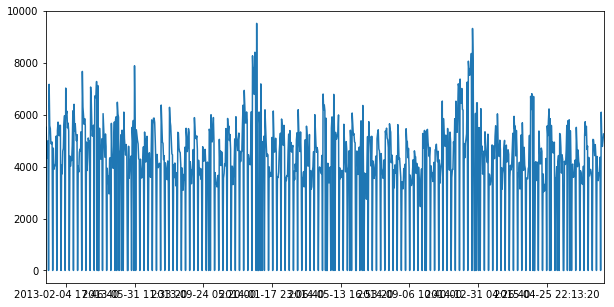

In [58]:
store = 1

import matplotlib.dates as mdates
import matplotlib as mpl

def datetimeformatter(x, pos):
    return pd.to_datetime(x)

df_ts = df_train.copy()
df_ts.sort_values('Date')
date = pd.to_datetime(df_ts[df_ts['Store'] == store].Date).values.astype('datetime64[D]')
sales = df_ts[df_ts['Store'] == store].Sales
fig, axes = plt.subplots(figsize=(10,5))
sns.tsplot(sales, date, ax = axes)
axes.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(datetimeformatter))
plt.show()

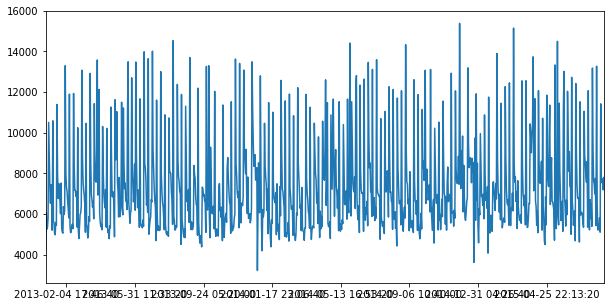

In [59]:
store = 85

import matplotlib.dates as mdates
import matplotlib as mpl

def datetimeformatter(x, pos):
    return pd.to_datetime(x)

df_ts = df_train.copy()
df_ts.sort_values('Date')
date = pd.to_datetime(df_ts[df_ts['Store'] == store].Date).values.astype('datetime64[D]')
sales = df_ts[df_ts['Store'] == store].Sales
fig, axes = plt.subplots(figsize=(10,5))
sns.tsplot(sales, date, ax = axes)
axes.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(datetimeformatter))
plt.show()

The reason for this observation is because Some stores is not open on Sunday. This is an excellent feature that we can include in our training data as we can immediately predict that the sales is zero if the particular store is not open on Sunday!

In [60]:
store = 1
df_indiv_store = df_train[df_train['Store'] == store]
df_indiv_store.groupby('DayOfWeek').Open.sum()

DayOfWeek
1    128
2    134
3    132
4    124
5    129
6    134
7      0
Name: Open, dtype: int64

In [61]:
store = 85
df_indiv_store = df_train[df_train['Store'] == store]
df_indiv_store.groupby('DayOfWeek').Open.sum()

DayOfWeek
1    134
2    135
3    135
4    135
5    135
6    134
7    134
Name: Open, dtype: int64

the `CompetitionOpenSinceYear` column looks fishy as the minimum value is 1900. I'm suspicious that it is an outlier value. To simplify the features and removing the excessive number of dummy variables, we will concatenate all stores that are open before year 2000. It does not make sense to retain the class as some Year have too few observations.

In [18]:
df_stores.groupby('CompetitionOpenSinceYear').size()

CompetitionOpenSinceYear
1900.0     1
1961.0     1
1990.0     5
1994.0     2
1995.0     2
1998.0     1
1999.0     8
2000.0    10
2001.0    16
2002.0    27
2003.0    19
2004.0    22
2005.0    62
2006.0    47
2007.0    48
2008.0    54
2009.0    54
2010.0    55
2011.0    54
2012.0    82
2013.0    83
2014.0    70
2015.0    38
dtype: int64

## Feature Engineering

As we would like to perform feature engineering, we will concat the train and test dataset temporarily. This allows us to create features for both datasets at one go. Furthermore, later we will extract features based on the store Id across all test and train observations. 

In performing this concat, we need to create dummy column for train `Id`, test `Sales`, and test `Customers`. We will also create `TrainTest` column to identify whether the observation come from a `Train` dataset or `Test` Dataset. 

In [11]:
def create_df_merge(train_df, test_df):
    df_train = train_df.copy()
    df_test = test_df.copy()
    df_train['Id'] = df_train.index
    df_test['Sales'] = 0.
    df_test['Customers'] = 0.
    df_train['TrainTest'] = 'Train'
    df_test['TrainTest'] = 'Test'
    df_train = df_train[sorted(df_train.columns)]
    df_test = df_test[sorted(df_test.columns)]
    assert df_train.columns.tolist() == df_test.columns.tolist()
    df_merge = pd.concat([df_train, df_test])
    return df_merge

The first Feature engineering is to create basic features, which is defined as features that are engineered from other columns within that observations. We will also transform some numerical features which should have been a categorical features into string, so that we are able to perform one-hot encoding using `pd.get_dummmies()` later. The features that we have engineered in the `create_basic_features` are:

- `Year` - Year of the observation. Derived from `Date`
- `Month` - Month of the observation. Derived from `Date`
- `Week` - Week of the observation. Derived from `Date`
- `Day` - Day of the observation. Derived from `Date`
- Simplifying `StateHoliday` - Only stating whether today is a holiday or not
- Filling up `CompetitionDistance` missing values with the mean between all `CompetitionDistance`
- Removing outliers on `CompetitionOpenSinceYear`. All observations before year 2000 is converted into year 2000.
- Filling up `CompetitionOpenSinceMonth` missing values with January
- Forcing `CompetitionDistance` values to be zero if the Competition store has not been open during the date of the observation. This steps makes sense because that means there are currently no competition around the drug store.
- Create column `CompetitionDaysElapsed` which tracks how many days the competitior stores has been opened at the time of the observation.
- Create column `Promo2DaysSinceElapsed` which tracks how many days the store have joined the `Promo2` sales at the time of the observation.


In [12]:
def create_basic_features(df):
    df.Date = pd.to_datetime(df.Date)
    df["Store"] = df["Store"].astype(str)
    df["DayOfWeek"] = df["DayOfWeek"].astype(str)
    df["Year"] = df.Date.dt.year.astype(str)
    df["Month"] = df.Date.dt.month.astype(str)
    df["Week"] = df.Date.dt.week.astype(str)
    df["Day"] = df.Date.dt.day.astype(str)
    df['StateHoliday'] = df['StateHoliday'] != '0'
    df['SchoolHoliday'] = df['SchoolHoliday'] != 0
    df['Open'] = df['Open'] != 0
    df['Promo'] = df['Promo'] != 0
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].mean())
    df.loc[df['CompetitionOpenSinceYear'] < 2000, 'CompetitionOpenSinceYear'] = 2000
    df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(2000).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(1).astype(np.int32)
    df["CompetitionOpenSinceDateTime"] = pd.to_datetime(df.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 1), axis=1).astype(pd.datetime))
    df["CompetitionDaysElapsed"] = df.Date.subtract(df["CompetitionOpenSinceDateTime"]).dt.days
    competition_distance = df['CompetitionDistance'].values
    competition_elapsed = df['CompetitionDaysElapsed'].values
    df['CompetitionDistance'] = np.where(competition_elapsed>= 0., competition_distance, 0.)
    df['CompetitionDaysElapsed'] = np.where(competition_elapsed >= 0., competition_elapsed, 0.)
    df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(2009).astype(np.int32)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(1).astype(np.int32)
    df["Promo2SinceDateTime"] = pd.to_datetime(df.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2SinceDaysElapsed"] = df.Date.subtract(df["Promo2SinceDateTime"]).dt.days
    return df

We will also try to create `advanced_features` which is dependent on the `Store` ID of the observation. The features that we want to create for each store are
- `sales_mean` - the mean of the sales for a particular store over train period
- `customer_mean` - the mean of the customer coming to the store in a day for a particular store over train period
- `is_open_sunday` - Whether the store is open on Sunday. After performing some observation, I identify that some of the stores are not open at all on sunday
- `state_hols_array` - The starting dates of all state holidays for the particular store over all train and test dataset
- `school_hols_array` - The starting dates for all school holidays for the particular store over all train and test dataset
- `promo_array` - The starting dates for all promos for the particular store over all train and test dataset

In [13]:
def create_store_dictionary(merge_df):
    df = merge_df.copy()
    df = df.sort_values(['Date'])
    dict_store = {}
    for store in tqdm(np.unique(df.Store)):
        df_store = df[df.Store == store]
        sales_mean = df.loc[(df.Sales > 0.0) & (df.Store == store),"Sales"].mean()
        customer_mean = df.loc[(df.Customers > 0.0) & (df.Store == store), "Customers"].mean()
        is_open_sunday = df.loc[(df.Sales > 0.0) & (df.DayOfWeek == 7) & (df.Store == store),"Customers"].empty
        state_hols_array = df_store.StateHoliday.values
        state_hols_starting_date = df_store.Date[np.append([state_hols_array[0] == 1], (state_hols_array[:-1] == 0) & (state_hols_array[1:] == 1))].values
        school_hols_array = df_store.SchoolHoliday.values
        school_hols_starting_date = df_store.Date[np.append([school_hols_array[0] == 1], (school_hols_array[:-1] == 0) & (school_hols_array[1:] == 1))].values
        promo_array = df_store.Promo.values
        promo_starting_date = df_store.Date[np.append([promo_array[0] == 1], (promo_array[:-1] == 0) & (promo_array[1:] == 1))].values
        dict_store[store] = {
            'sales_mean' : sales_mean,
            'customer_mean' : customer_mean,
            'is_open_sunday' : is_open_sunday,
            'state_hols_array' : state_hols_starting_date,
            'school_hols_array' : school_hols_starting_date,
            'promo_array' : promo_starting_date
        }
    return dict_store

- We will then create a function that is able to return the `sales_mean`, `customer_mean`, and `is_open_sunday` given an array of stores. 

- We will also engineer a feature that tracks the upcoming and previous holiday/promo. 

- `before_state_hols_date`, `before_school_hols_date`, and `before_promo_date` return the number of days remaining before the next State Holiday / School Holiday / Promo in that store 

- `after_state_hols_date`, `after_school_hols_date`, and `after_promo_date` returns the number of days that have elapsed since the last State Holiday / School Holiday / Promo that happens in that store.

In [14]:
def get_sales_mean(dict_store, array_store):
    array_sales_mean = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        array_sales_mean[idx] = dict_store[array_store[idx]]['sales_mean']
    return array_sales_mean

def get_customer_mean(dict_store, array_store):
    customer_sales_mean = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        customer_sales_mean[idx] = dict_store[array_store[idx]]['customer_mean']
    return customer_sales_mean

def get_is_open_sunday(dict_store, array_store):
    is_open_sunday_mean = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        is_open_sunday_mean[idx] = dict_store[array_store[idx]]['is_open_sunday']
    return is_open_sunday_mean

def before_state_hols_date(dict_store, array_date, array_store, array_state_hols):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_state_hols[idx] == True:
            result[idx] = 0
        else:
            store_array_date = dict_store[array_store[idx]]['state_hols_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            before_values = np.abs(value[np.where(value <= 0.0)])
            if len(before_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(before_values)
    return result

def after_state_hols_date(dict_store, array_date, array_store, array_state_hols):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_state_hols[idx] == True:
            result[idx] = 0
        else:
            store_array_date = dict_store[array_store[idx]]['state_hols_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            after_values = value[np.where(value >= 0.0)]
            if len(after_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(after_values)
    return result

def before_school_hols_date(dict_store, array_date, array_store, array_school_hols):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_school_hols[idx] == True:
            result[idx] = 0
        else:
            store_array_date = dict_store[array_store[idx]]['school_hols_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            before_values = np.abs(value[np.where(value <= 0.0)])
            if len(before_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(before_values)
    return result

def after_school_hols_date(dict_store, array_date, array_store, array_school_hols):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_school_hols[idx] == True:
            result[idx] = 0 
        else:
            store_array_date = dict_store[array_store[idx]]['school_hols_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            after_values = value[np.where(value >= 0.0)]
            if len(after_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(after_values)
    return result

def before_promo_date(dict_store, array_date, array_store, array_promo):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_promo[idx] == True:
            result[idx] = 0
        else:
            store_array_date = dict_store[array_store[idx]]['promo_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            before_values = np.abs(value[np.where(value <= 0.0)])
            if len(before_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(before_values)
    return result

def after_promo_date(dict_store, array_date, array_store, array_promo):
    result = np.zeros(len(array_store))
    for idx in range(len(array_store)):
        if array_promo[idx] == True:
            result[idx] = 0
        else:
            store_array_date = dict_store[array_store[idx]]['promo_array'].astype('datetime64[D]')
            value = store_array_date - np.datetime64(array_date[idx], 'D')
            value = value.astype(float)
            after_values = value[np.where(value >= 0.0)]
            if len(after_values) == 0:
                result[idx] = 0
            else:
                result[idx] = np.min(after_values)
    return result

In [15]:
def create_advanced_features(df, dict_store):
    array_store = df['Store'].values
    array_date = df['Date'].values
    array_state_hols = df['StateHoliday'].values
    array_school_hols = df['SchoolHoliday'].values
    array_promo = df['Promo'].values
    df['sales_mean'] = get_sales_mean(dict_store, array_store)
    df['customer_mean'] = get_customer_mean(dict_store, array_store)
    df['is_open_sunday'] = get_is_open_sunday(dict_store, array_store)
    df['prev_StateHoliday'] = before_state_hols_date(dict_store, array_date, array_store, array_state_hols)
    df['next_StateHoliday'] = after_state_hols_date(dict_store, array_date, array_store, array_state_hols)
    df['prev_SchoolHoliday'] = before_school_hols_date(dict_store, array_date, array_store, array_school_hols)
    df['next_SchoolHoliday'] = after_school_hols_date(dict_store, array_date, array_store, array_school_hols)
    df['prev_Promo'] = before_promo_date(dict_store, array_date, array_store, array_promo)
    df['next_Promo'] = after_promo_date(dict_store, array_date, array_store, array_promo)
    return df

After we finish with the feature engineering, we can then identify all the categorical features that we have in our dataset. We can then create dummy variables for each categorical features in our dataset. We will then split the train test set back, according to our `TrainTest` label. 

All the features that we would like to use to train the data is at `X_train`. `X_test` contains all the features of the test data. Lastly, `Y_train` contains the Sales value for our train dataset

In [16]:
def create_train_test_split(df, one_hot = True):
    all_features = ['DayOfWeek', 'Open',
                   u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'Year', u'Month', u'Week',
       u'Day', u'CompetitionDaysElapsed',
        u'Promo2SinceDaysElapsed', u'sales_mean',
       u'customer_mean', u'is_open_sunday', u'prev_StateHoliday',
       u'next_StateHoliday', u'prev_SchoolHoliday', u'next_SchoolHoliday',
       u'prev_Promo', u'next_Promo', 'TrainTest', 'Sales']
    cat_features = ['DayOfWeek', 'StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                   'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Week', 'Day']
    for x in cat_features:
        df[x] = df[x].astype(str)
    df = df[all_features]
    if one_hot:
        df = pd.get_dummies(df, prefix = cat_features, columns= cat_features)
    else:
        df = df
    df_train = df[df['TrainTest'] == 'Train']
    df_test  = df[df['TrainTest'] == 'Test']
    
    df_X_train =  df_train.drop(['TrainTest', 'Sales'], axis = 1)
    df_X_test = df_test.drop(['TrainTest', 'Sales'], axis = 1)
    
    assert df_X_train.columns.tolist() == df_X_test.columns.tolist()
    
    X_train = df_X_train.values
    X_test = df_X_test.values
    Y_train = df_train['Sales'].values
    
    return X_train, Y_train, X_test, df_X_train.columns

We concatenate all the feature engineering/data cleansing procedure to the train/test dataset in this `run_processing_pipeline` feature

In [17]:
def run_preprocessing_pipeline(df_train, df_test, one_hot = True):
    df_merge = create_df_merge(df_train, df_test)
    df_merge_basic_feat = create_basic_features(df_merge)
    dict_store = create_store_dictionary(df_merge)
    df_merge_adv_feat = create_advanced_features(df_merge, df_store)
    X_train, Y_train, X_test, column_names = create_train_test_split(df_features, one_hot)
    return  X_train, Y_train, X_test, column_names

In [18]:
df_merge = create_df_merge(df_train, df_test)

In [18]:
df_merge_basic_feat = create_basic_features(df_merge)

In [57]:
dict_store = create_store_dictionary(df_merge)

In [69]:
df_merge_adv_feat = create_advanced_features(df_merge, dict_store)

In [97]:
X_train, Y_train, X_test, column_names = create_train_test_split(df_merge_adv_feat, one_hot = True)

Sanity Check to ensure that the number of observations does not decreases after the feature engineering as I do not perform any outlier removal in this dataset

In [31]:
print X_train.shape
print Y_train.shape
print X_test.shape

(1017209, 188)
(1017209,)
(41088, 188)


To allow easy exporting/importing of our training/test array, we store it in a `pickle` format

In [99]:
joblib.dump(df_merge_basic_feat, 'df_merge_basic_feat.pkl') 
joblib.dump(dict_store, 'dict_store.pkl') 
joblib.dump(df_merge_adv_feat, 'df_merge_adv_feat.pkl') 
joblib.dump(X_train, 'X_train.pkl') 
joblib.dump(Y_train, 'Y_train.pkl') 
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(column_names, 'column_names.pkl')

['column_names.pkl']

In [62]:
df_merge_basic_feat = joblib.load('df_merge_basic_feat.pkl')
dict_store = joblib.load('dict_store.pkl')
df_merge_adv_feat = joblib.load('df_merge_adv_feat.pkl')
X_full_train = joblib.load('X_train.pkl')
Y_full_train = joblib.load('Y_train.pkl')
X_test = joblib.load('X_test.pkl')
column_names = joblib.load('column_names.pkl')

For the validation, we will use simple train-test split function provided from the `sklearn` package. We will set aside 20% of our data to evaluate the performance of our various models used in predicting the Sales of the Rossmann stores. `X_val` and `Y_val` indicates the features and the ground truth Sales of our observations from the train dataset which is excluded from the training process

In [65]:
X_train, X_val, Y_train, Y_val = train_test_split(X_full_train, Y_full_train, test_size = 0.20, random_state = 1234)

The lists provides all of the column names of the features that I will include in the Sales prediction. 

In [6]:
column_names.tolist()

['Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'CompetitionDistance',
 'Promo2',
 'CompetitionDaysElapsed',
 'Promo2SinceDaysElapsed',
 'sales_mean',
 'customer_mean',
 'is_open_sunday',
 'prev_StateHoliday',
 'next_StateHoliday',
 'prev_SchoolHoliday',
 'next_SchoolHoliday',
 'prev_Promo',
 'next_Promo',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c',
 'CompetitionOpenSinceMonth_1',
 'CompetitionOpenSinceMonth_10',
 'CompetitionOpenSinceMonth_11',
 'CompetitionOpenSinceMonth_12',
 'CompetitionOpenSinceMonth_2',
 'CompetitionOpenSinceMonth_3',
 'CompetitionOpenSinceMonth_4',
 'CompetitionOpenSinceMonth_5',
 'CompetitionOpenSinceMonth_6',
 'CompetitionOpenSinceMonth_7',
 'CompetitionOpenSinceMonth_8',
 'CompetitionOpenSinceMonth_9',
 'CompetitionOpenSinceYear_2000',
 'CompetitionOpenSinceYear_2001',
 'C

Last Sanity Check to ensure that there are no suspicious values in the dataset after performing feature engineering / data cleansing. I have also ensured that there are no more missing values in all features that I will use in training the model. It should be noted that I will not use `PromoInterval` as part of the prediction in this model

In [7]:
df_merge_adv_feat.head()

,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Id,Open,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,SchoolHoliday,StateHoliday,Store,StoreType,TrainTest,Year,Month,Week,Day,CompetitionOpenSinceDateTime,CompetitionDaysElapsed,Promo2SinceDateTime,Promo2SinceDaysElapsed,sales_mean,customer_mean,is_open_sunday,prev_StateHoliday,next_StateHoliday,prev_SchoolHoliday,next_SchoolHoliday,prev_Promo,next_Promo
0,a,1270.0,9,2008,555.0,2015-07-31,5,0,True,True,0,1,2009,NaN,5263.0,True,False,1,c,Train,2015,7,31,31,2008-09-01,2524.0,2008-12-29,2405,4759.096031,564.049936,1.0,57.0,0.0,0.0,0.0,0.0,0.0
1,a,1270.0,9,2008,546.0,2015-07-30,4,1,True,True,0,1,2009,NaN,5020.0,True,False,1,c,Train,2015,7,31,30,2008-09-01,2523.0,2008-12-29,2404,4759.096031,564.049936,1.0,56.0,0.0,0.0,0.0,0.0,0.0
2,a,1270.0,9,2008,523.0,2015-07-29,3,2,True,True,0,1,2009,NaN,4782.0,True,False,1,c,Train,2015,7,31,29,2008-09-01,2522.0,2008-12-29,2403,4759.096031,564.049936,1.0,55.0,0.0,0.0,0.0,0.0,0.0
3,a,1270.0,9,2008,560.0,2015-07-28,2,3,True,True,0,1,2009,NaN,5011.0,True,False,1,c,Train,2015,7,31,28,2008-09-01,2521.0,2008-12-29,2402,4759.096031,564.049936,1.0,54.0,0.0,0.0,0.0,0.0,0.0
4,a,1270.0,9,2008,612.0,2015-07-27,1,4,True,True,0,1,2009,NaN,6102.0,True,False,1,c,Train,2015,7,31,27,2008-09-01,2520.0,2008-12-29,2401,4759.096031,564.049936,1.0,53.0,0.0,0.0,0.0,0.0,0.0


In [8]:
DataFrameSummary(df_merge_adv_feat).summary()

,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Id,Open,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,SchoolHoliday,StateHoliday,Store,StoreType,TrainTest,Year,Month,Week,Day,CompetitionOpenSinceDateTime,CompetitionDaysElapsed,Promo2SinceDateTime,Promo2SinceDaysElapsed,sales_mean,customer_mean,is_open_sunday,prev_StateHoliday,next_StateHoliday,prev_SchoolHoliday,next_SchoolHoliday,prev_Promo,next_Promo
count,NaN,1.0583e+06,NaN,NaN,1.0583e+06,NaN,NaN,1.0583e+06,NaN,NaN,1.0583e+06,NaN,NaN,NaN,1.0583e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0583e+06,NaN,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06,1.0583e+06
mean,NaN,4977.7,NaN,NaN,608.564,NaN,NaN,489655,NaN,NaN,0.503671,NaN,NaN,NaN,5549.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2902.97,NaN,1361.48,6940.16,757.689,1,30.6031,24.3145,26.1157,22.7906,5.65169,3.10491
std,NaN,7516.57,NaN,NaN,471.449,NaN,NaN,302941,NaN,NaN,0.499987,NaN,NaN,NaN,3935.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.87,NaN,773.68,2387,355.863,0,31.0979,29.8057,23.55,23.0989,6.83561,3.32256
min,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-881,2703.74,240.183,1,0,0,0,0,0,0
25%,NaN,450,NaN,NaN,363,NaN,NaN,223486,NaN,NaN,0,NaN,NaN,NaN,3319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,928,NaN,775,5321.14,543.676,1,4,1,6,2,0,0
50%,NaN,2060,NaN,NaN,594,NaN,NaN,488060,NaN,NaN,1,NaN,NaN,NaN,5600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2810,NaN,1576,6607.94,681.15,1,20,12,22,18,6,2
75%,NaN,6250,NaN,NaN,824,NaN,NaN,752634,NaN,NaN,1,NaN,NaN,NaN,7749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5004,NaN,1972,7967.27,867.466,1,52,38,41,37,10,6
max,NaN,75860,NaN,NaN,7388,NaN,NaN,1.01721e+06,NaN,NaN,1,NaN,NaN,NaN,41551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5738,NaN,2453,21757.5,3403.46,1,135,195,118,194,188,16
counts,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,533034,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297,1058297
uniques,3,655,12,16,4086,990,7,1017209,2,2,2,24,7,3,21734,2,2,1115,4,2,3,12,52,31,162,5739,56,3335,1115,1114,1,136,147,119,118,21,17


## Model

It should be noted that the submissions in the Kaggle competitions are evaluated using RMSPE ( Root Mean Square Percentage Error ) . As I am mostly using `sklearn` and `xgboost` package in my model building, and the evaluation method is not supported by both packages, I will need to create the function itself from scratch using sklearn's `make_scorer` function.

In [9]:
from sklearn.metrics import make_scorer

def rmpse_loss_func(ground_truth, predictions):
    idx = np.where(ground_truth > 0.)
    ground_truth = ground_truth[idx]
    predictions = predictions[idx]
    err = np.sqrt(np.mean((np.true_divide(predictions, ground_truth) - 1.)**2))
    return err

rmpse_loss  = make_scorer(rmpse_loss_func, greater_is_better=False)

There are few models that I will use in predicting the sales

- Linear regression
- Neural Network
- XGBoost with SKlearn wrapper
- Native XGBoost 
- Random Forest

I love tree ensemble method as they are more robust than linear models. As we do not perform any check on the distribution of values for each features in our training dataset, I hypothesize that the performance of all the tree ensembles will not be significantly impacted. Also, in this assignment I would like to try both XGBoost with the SKLearn wrapper as well as their native implementation as I want to try how does the XGBoost with SKlearn wrapper perform in conjunction with the hyperparameter tuning function `RandomizedSearchCV` provided under `sklearn` package

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.models import Model
from keras import backend as K
from xgboost import XGBRegressor

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Linear Regression

The Linear Regression Model is set up as a baseline for all of the other model.

In [242]:
linear_model = LinearRegression().fit(X_train, Y_train)

# NN 

I am also trying to use Deep Neural Network as one of the predictive model. T

In [278]:
NN_idx = np.where(Y_train != 0.)
X_train_NN = X_train[NN_idx]
Y_train_NN = Y_train[NN_idx]

In [279]:
def rmspe_NN(y_true, y_pred):
    err = K.sqrt(K.mean(((y_pred / y_true) - 1.)**2))
    return err

In [286]:
inputs = Input(shape = (X_train_NN.shape[1],), name='Input')
X = Dense(2048, name='Dense1', activation='relu')(inputs)
X = BatchNormalization(name='BN1')(X)
X = Dropout(rate= 0.25)(X)
X = Dense(1024, name='Dense2', activation='relu')(X)
X = BatchNormalization(name='BN2')(X)
X = Dropout(rate= 0.20)(X)
X = Dense(512, name='Dense3', activation='relu')(X)
X = BatchNormalization(name='BN3')(X)
X = Dropout(rate= 0.15)(X)
X = Dense(256, name='Dense4', activation='relu')(X)
X = BatchNormalization(name='BN4')(X)
X = Dropout(rate= 0.10)(X)
X = Dense(128, name='Dense5', activation='relu')(X)
X = BatchNormalization(name='BN5')(X)
X = Dropout(rate= 0.05)(X)
outputs = Dense(1, name='Dense6', activation='relu')(X)

In [287]:
NN_model = Model(inputs=inputs, outputs=outputs, name='NN_Model')
NN_model.compile('adam', 'mean_squared_error' , metrics=[rmspe_NN])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 188)               0         
_________________________________________________________________
Dense1 (Dense)               (None, 2048)              387072    
_________________________________________________________________
BN1 (BatchNormalization)     (None, 2048)              8192      
_________________________________________________________________
dropout_31 (Dropout)         (None, 2048)              0         
_________________________________________________________________
Dense2 (Dense)               (None, 1024)              2098176   
_________________________________________________________________
BN2 (BatchNormalization)     (None, 1024)              4096      
_________________________________________________________________
dropout_32 (Dropout)         (None, 1024)              0         
__________

In [289]:
NN_model.fit(X_train_NN, Y_train_NN, epochs=5, batch_size=64)

Epoch 1/3
675490/675490 [==============================] - 534s 791us/step - loss: 2347962.6519 - rmspe_NN: 0.2605
Epoch 2/3
675490/675490 [==============================] - 530s 785us/step - loss: 2210722.0510 - rmspe_NN: 0.2567
Epoch 3/3
675490/675490 [==============================] - 531s 785us/step - loss: 2155088.0333 - rmspe_NN: 0.2547


In [ ]:
NN_model.save('NN_model.h5')

In [64]:
NN_model = load_model('NN_model.h5')

In [66]:
NN_model.predict(X_val)

array([[5878.584  ],
       [6601.199  ],
       [5187.9087 ],
       ...,
       [9348.835  ],
       [4769.8706 ],
       [ 339.13083]], dtype=float32)

## Xgboost - SKLearn Wrapper 

In [58]:
xgb_model = XGBRegressor(objective = 'reg:linear', booster = 'gbtree', eta = 0.02, max_depth = 12, subsample = 0.9, colsample_bytree = 0.7, silent = False, n_jobs = 8)

In [59]:
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.02, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=12, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=8, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.9)

In [42]:
xgb_params = {
    'learning_rate' : np.arange(0.01, 0.21, 0.01),
    'max_depth' : np.arange(3, 25, 1),
    'gamma' : np.arange(0., 3., 1.),
}

In [41]:
start = time.time()
xgb_CV_model = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, n_iter= 10, scoring='neg_mean_squared_error', cv=3, verbose=4, n_jobs = 1,  return_train_score = True).fit(X_train, Y_train)
end = time.time()
end - start

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] gamma=3.0, learning_rate=0.060000000000000005, colsample_bytree=0.9999999999999999, max_depth=6, min_child_weight=1 
[CV]  gamma=3.0, learning_rate=0.060000000000000005, colsample_bytree=0.9999999999999999, max_depth=6, min_child_weight=1, score=-1058330.77212, total= 1.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] gamma=3.0, learning_rate=0.060000000000000005, colsample_bytree=0.9999999999999999, max_depth=6, min_child_weight=1 
[CV]  gamma=3.0, learning_rate=0.060000000000000005, colsample_bytree=0.9999999999999999, max_depth=6, min_child_weight=1, score=-1229509.33876, total= 1.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV] gamma=3.0, learning_rate=0.060000000000000005, colsample_bytree=0.9999999999999999, max_depth=6, min_child_weight=1 
[CV]  gamma=3.0, learning_rate=0.060000000000000005, colsample_bytree=0.9999999999999999, max_depth=6, min_child_weight=1, score=-1128630.50722, total= 1.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s


[CV] gamma=1.0, learning_rate=0.03, colsample_bytree=0.9999999999999999, max_depth=3, min_child_weight=1 
[CV]  gamma=1.0, learning_rate=0.03, colsample_bytree=0.9999999999999999, max_depth=3, min_child_weight=1, score=-1912769.86368, total= 1.0min
[CV] gamma=1.0, learning_rate=0.03, colsample_bytree=0.9999999999999999, max_depth=3, min_child_weight=1 
[CV]  gamma=1.0, learning_rate=0.03, colsample_bytree=0.9999999999999999, max_depth=3, min_child_weight=1, score=-2143057.32365, total= 1.0min
[CV] gamma=1.0, learning_rate=0.03, colsample_bytree=0.9999999999999999, max_depth=3, min_child_weight=1 
[CV]  gamma=1.0, learning_rate=0.03, colsample_bytree=0.9999999999999999, max_depth=3, min_child_weight=1, score=-2032364.68996, total= 1.0min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.1min finished


692.3348560333252

In [303]:
xgb_CV_model = joblib.load("xgb_CV_model.pkl")

## Native SKlearn

In [306]:
dtrain = xgb.DMatrix(X_train, label= Y_train)

In [312]:
dtest = xgb.DMatrix(X_val, label=Y_val)

In [317]:
def rmpse(preds, dtrain):
    labels = dtrain.get_label()
    idx = np.where(labels > 0.)
    labels = labels[idx]
    preds = preds[idx]
    err = np.sqrt(np.mean((np.true_divide(preds, labels) - 1.)**2))
    return 'error', err

In [318]:
watchlist = [(dtest, 'eval'), (dtrain, 'train')]

In [319]:
param = { 'objective' : "reg:linear", 
          'booster' : "gbtree",
          'eta'                 :0.05, 
          'max_depth'           :9, 
          'subsample'           : 0.9,
          'colsample_bytree'    : 0.7,
          'n_thread' : 8
        }

In [ ]:
bst = xgb.Booster()
bst.load_model('bst.model')

In [320]:
bst = xgb.train(param, dtrain, evals=watchlist, num_boost_round = 2000, feval= rmpse, maximize = False)

[0]	eval-rmse:6634.19	train-rmse:6629.6	eval-error:0.943625	train-error:0.943758
[1]	eval-rmse:6316.96	train-rmse:6312.4	eval-error:0.895238	train-error:0.895542
[2]	eval-rmse:6013.8	train-rmse:6009.41	eval-error:0.848785	train-error:0.849286
[3]	eval-rmse:5724.96	train-rmse:5720.79	eval-error:0.805014	train-error:0.805767
[4]	eval-rmse:5454.02	train-rmse:5449.88	eval-error:0.763989	train-error:0.765031
[5]	eval-rmse:5198.88	train-rmse:5194.77	eval-error:0.724168	train-error:0.725551
[6]	eval-rmse:4952.51	train-rmse:4948.47	eval-error:0.68725	train-error:0.689047
[7]	eval-rmse:4719.42	train-rmse:4715.43	eval-error:0.652359	train-error:0.654613
[8]	eval-rmse:4503.21	train-rmse:4499.14	eval-error:0.618927	train-error:0.621629
[9]	eval-rmse:4295.31	train-rmse:4291.18	eval-error:0.588336	train-error:0.591588
[10]	eval-rmse:4101.54	train-rmse:4097.56	eval-error:0.558605	train-error:0.562394
[11]	eval-rmse:3913.86	train-rmse:3910.07	eval-error:0.531175	train-error:0.535585
[12]	eval-rmse:374

[100]	eval-rmse:920.501	train-rmse:900.014	eval-error:0.204668	train-error:0.236846
[101]	eval-rmse:919.107	train-rmse:898.454	eval-error:0.204475	train-error:0.236643
[102]	eval-rmse:917.656	train-rmse:896.869	eval-error:0.204374	train-error:0.236572
[103]	eval-rmse:915.864	train-rmse:894.924	eval-error:0.204136	train-error:0.236343
[104]	eval-rmse:914.224	train-rmse:893.118	eval-error:0.203818	train-error:0.235675
[105]	eval-rmse:912.866	train-rmse:891.646	eval-error:0.20373	train-error:0.23525
[106]	eval-rmse:911.411	train-rmse:890.005	eval-error:0.203589	train-error:0.235018
[107]	eval-rmse:909.916	train-rmse:888.412	eval-error:0.203369	train-error:0.234769
[108]	eval-rmse:908.829	train-rmse:887.159	eval-error:0.203229	train-error:0.234317
[109]	eval-rmse:907.56	train-rmse:885.7	eval-error:0.203192	train-error:0.234144
[110]	eval-rmse:905.603	train-rmse:883.559	eval-error:0.2029	train-error:0.233531
[111]	eval-rmse:903.797	train-rmse:881.575	eval-error:0.2026	train-error:0.232866
[

[199]	eval-rmse:817.998	train-rmse:784.401	eval-error:0.18442	train-error:0.211036
[200]	eval-rmse:817.244	train-rmse:783.479	eval-error:0.184341	train-error:0.210836
[201]	eval-rmse:816.644	train-rmse:782.786	eval-error:0.184163	train-error:0.210731
[202]	eval-rmse:816.322	train-rmse:782.395	eval-error:0.184094	train-error:0.210651
[203]	eval-rmse:815.928	train-rmse:781.907	eval-error:0.184055	train-error:0.21065
[204]	eval-rmse:815.685	train-rmse:781.547	eval-error:0.184003	train-error:0.210542
[205]	eval-rmse:815.068	train-rmse:780.859	eval-error:0.183809	train-error:0.210409
[206]	eval-rmse:814.613	train-rmse:780.27	eval-error:0.18376	train-error:0.21032
[207]	eval-rmse:814.048	train-rmse:779.566	eval-error:0.183663	train-error:0.21023
[208]	eval-rmse:812.98	train-rmse:778.491	eval-error:0.183484	train-error:0.21001
[209]	eval-rmse:812.581	train-rmse:777.932	eval-error:0.183457	train-error:0.210001
[210]	eval-rmse:812.151	train-rmse:777.387	eval-error:0.183396	train-error:0.209944


[298]	eval-rmse:768.57	train-rmse:725.115	eval-error:0.17213	train-error:0.195419
[299]	eval-rmse:768.293	train-rmse:724.676	eval-error:0.172096	train-error:0.195372
[300]	eval-rmse:767.696	train-rmse:723.916	eval-error:0.171988	train-error:0.195259
[301]	eval-rmse:767.538	train-rmse:723.696	eval-error:0.171952	train-error:0.194971
[302]	eval-rmse:766.982	train-rmse:722.982	eval-error:0.171878	train-error:0.194109
[303]	eval-rmse:766.754	train-rmse:722.689	eval-error:0.171846	train-error:0.193987
[304]	eval-rmse:766.612	train-rmse:722.489	eval-error:0.17176	train-error:0.193928
[305]	eval-rmse:766.276	train-rmse:722.062	eval-error:0.17171	train-error:0.193882
[306]	eval-rmse:765.931	train-rmse:721.64	eval-error:0.171633	train-error:0.193818
[307]	eval-rmse:765.786	train-rmse:721.395	eval-error:0.171628	train-error:0.193775
[308]	eval-rmse:765.376	train-rmse:720.736	eval-error:0.17154	train-error:0.19367
[309]	eval-rmse:765.102	train-rmse:720.398	eval-error:0.171513	train-error:0.193608

[397]	eval-rmse:731.473	train-rmse:678.91	eval-error:0.161999	train-error:0.182938
[398]	eval-rmse:730.895	train-rmse:678.247	eval-error:0.161936	train-error:0.182874
[399]	eval-rmse:730.773	train-rmse:678.031	eval-error:0.161865	train-error:0.182869
[400]	eval-rmse:730.095	train-rmse:677.259	eval-error:0.161517	train-error:0.182753
[401]	eval-rmse:729.693	train-rmse:676.807	eval-error:0.161386	train-error:0.182623
[402]	eval-rmse:729.48	train-rmse:676.481	eval-error:0.16133	train-error:0.182575
[403]	eval-rmse:729.251	train-rmse:676.195	eval-error:0.161185	train-error:0.182374
[404]	eval-rmse:728.972	train-rmse:675.89	eval-error:0.161134	train-error:0.182322
[405]	eval-rmse:728.7	train-rmse:675.536	eval-error:0.161073	train-error:0.182275
[406]	eval-rmse:728.626	train-rmse:675.41	eval-error:0.16104	train-error:0.182261
[407]	eval-rmse:728.271	train-rmse:674.968	eval-error:0.160988	train-error:0.18222
[408]	eval-rmse:728.032	train-rmse:674.669	eval-error:0.160537	train-error:0.182143
[

[496]	eval-rmse:707.032	train-rmse:647.135	eval-error:0.155336	train-error:0.176584
[497]	eval-rmse:706.677	train-rmse:646.702	eval-error:0.155274	train-error:0.176386
[498]	eval-rmse:706.545	train-rmse:646.495	eval-error:0.155255	train-error:0.176335
[499]	eval-rmse:706.288	train-rmse:646.143	eval-error:0.155193	train-error:0.176289
[500]	eval-rmse:706.181	train-rmse:646.003	eval-error:0.155188	train-error:0.176284
[501]	eval-rmse:706.081	train-rmse:645.843	eval-error:0.155133	train-error:0.176219
[502]	eval-rmse:705.905	train-rmse:645.568	eval-error:0.1551	train-error:0.176179
[503]	eval-rmse:705.247	train-rmse:644.864	eval-error:0.154517	train-error:0.176108
[504]	eval-rmse:704.998	train-rmse:644.584	eval-error:0.154444	train-error:0.176037
[505]	eval-rmse:704.864	train-rmse:644.429	eval-error:0.154401	train-error:0.175977
[506]	eval-rmse:704.546	train-rmse:643.978	eval-error:0.154385	train-error:0.175915
[507]	eval-rmse:704.329	train-rmse:643.711	eval-error:0.154363	train-error:0.1

[595]	eval-rmse:688.111	train-rmse:621.433	eval-error:0.149492	train-error:0.170748
[596]	eval-rmse:687.916	train-rmse:621.194	eval-error:0.14945	train-error:0.170713
[597]	eval-rmse:687.843	train-rmse:621.073	eval-error:0.149439	train-error:0.170642
[598]	eval-rmse:686.961	train-rmse:620.099	eval-error:0.149158	train-error:0.170371
[599]	eval-rmse:686.863	train-rmse:619.894	eval-error:0.149132	train-error:0.170352
[600]	eval-rmse:686.64	train-rmse:619.595	eval-error:0.14911	train-error:0.170306
[601]	eval-rmse:686.519	train-rmse:619.368	eval-error:0.149062	train-error:0.170232
[602]	eval-rmse:686.431	train-rmse:619.204	eval-error:0.149048	train-error:0.170218
[603]	eval-rmse:686.39	train-rmse:619.149	eval-error:0.149045	train-error:0.170158
[604]	eval-rmse:686.139	train-rmse:618.816	eval-error:0.149014	train-error:0.170107
[605]	eval-rmse:686.022	train-rmse:618.663	eval-error:0.149005	train-error:0.170098
[606]	eval-rmse:685.696	train-rmse:618.26	eval-error:0.148923	train-error:0.1700

[693]	eval-rmse:672.121	train-rmse:598.978	eval-error:0.143924	train-error:0.166116
[694]	eval-rmse:672.057	train-rmse:598.849	eval-error:0.143893	train-error:0.166068
[695]	eval-rmse:671.962	train-rmse:598.718	eval-error:0.143887	train-error:0.166062
[696]	eval-rmse:671.757	train-rmse:598.424	eval-error:0.143828	train-error:0.165839
[697]	eval-rmse:671.654	train-rmse:598.262	eval-error:0.143814	train-error:0.165821
[698]	eval-rmse:671.528	train-rmse:598.076	eval-error:0.143789	train-error:0.1658
[699]	eval-rmse:671.473	train-rmse:597.969	eval-error:0.143776	train-error:0.165785
[700]	eval-rmse:671.393	train-rmse:597.839	eval-error:0.14376	train-error:0.165712
[701]	eval-rmse:671.324	train-rmse:597.722	eval-error:0.143748	train-error:0.165696
[702]	eval-rmse:671.049	train-rmse:597.367	eval-error:0.143675	train-error:0.165635
[703]	eval-rmse:671.025	train-rmse:597.321	eval-error:0.143673	train-error:0.16562
[704]	eval-rmse:670.895	train-rmse:597.104	eval-error:0.143632	train-error:0.165

[791]	eval-rmse:661.463	train-rmse:582.718	eval-error:0.140769	train-error:0.162182
[792]	eval-rmse:661.451	train-rmse:582.697	eval-error:0.140766	train-error:0.162178
[793]	eval-rmse:661.345	train-rmse:582.528	eval-error:0.14074	train-error:0.162154
[794]	eval-rmse:661.225	train-rmse:582.347	eval-error:0.140726	train-error:0.162144
[795]	eval-rmse:660.911	train-rmse:581.989	eval-error:0.140685	train-error:0.162119
[796]	eval-rmse:660.577	train-rmse:581.579	eval-error:0.140611	train-error:0.162046
[797]	eval-rmse:660.515	train-rmse:581.436	eval-error:0.140603	train-error:0.162012
[798]	eval-rmse:660.331	train-rmse:581.198	eval-error:0.140584	train-error:0.161991
[799]	eval-rmse:660.268	train-rmse:581.091	eval-error:0.140568	train-error:0.161975
[800]	eval-rmse:660.001	train-rmse:580.777	eval-error:0.140519	train-error:0.161895
[801]	eval-rmse:659.971	train-rmse:580.683	eval-error:0.140515	train-error:0.161885
[802]	eval-rmse:659.933	train-rmse:580.582	eval-error:0.140519	train-error:0.

[889]	eval-rmse:651.267	train-rmse:566.958	eval-error:0.138345	train-error:0.157234
[890]	eval-rmse:651.187	train-rmse:566.843	eval-error:0.138338	train-error:0.157224
[891]	eval-rmse:651.128	train-rmse:566.756	eval-error:0.138355	train-error:0.157211
[892]	eval-rmse:651.053	train-rmse:566.638	eval-error:0.138343	train-error:0.157182
[893]	eval-rmse:650.956	train-rmse:566.49	eval-error:0.138333	train-error:0.157154
[894]	eval-rmse:650.843	train-rmse:566.349	eval-error:0.138298	train-error:0.157102
[895]	eval-rmse:650.519	train-rmse:565.979	eval-error:0.138264	train-error:0.156996
[896]	eval-rmse:650.443	train-rmse:565.851	eval-error:0.138247	train-error:0.156969
[897]	eval-rmse:650.341	train-rmse:565.649	eval-error:0.138233	train-error:0.15694
[898]	eval-rmse:649.992	train-rmse:565.22	eval-error:0.138204	train-error:0.156946
[899]	eval-rmse:649.922	train-rmse:565.113	eval-error:0.138193	train-error:0.15726
[900]	eval-rmse:649.715	train-rmse:564.819	eval-error:0.138174	train-error:0.157

[988]	eval-rmse:640.124	train-rmse:550.674	eval-error:0.135641	train-error:0.155692
[989]	eval-rmse:640.041	train-rmse:550.519	eval-error:0.135626	train-error:0.15567
[990]	eval-rmse:639.978	train-rmse:550.415	eval-error:0.1356	train-error:0.155658
[991]	eval-rmse:639.953	train-rmse:550.307	eval-error:0.135594	train-error:0.155532
[992]	eval-rmse:639.938	train-rmse:550.266	eval-error:0.135592	train-error:0.155527
[993]	eval-rmse:639.812	train-rmse:550.056	eval-error:0.135602	train-error:0.155511
[994]	eval-rmse:639.708	train-rmse:549.887	eval-error:0.135588	train-error:0.155506
[995]	eval-rmse:639.68	train-rmse:549.826	eval-error:0.135586	train-error:0.155503
[996]	eval-rmse:639.654	train-rmse:549.763	eval-error:0.135581	train-error:0.155501
[997]	eval-rmse:639.586	train-rmse:549.66	eval-error:0.135573	train-error:0.155492
[998]	eval-rmse:639.275	train-rmse:549.307	eval-error:0.135468	train-error:0.155395
[999]	eval-rmse:639.056	train-rmse:549.019	eval-error:0.135402	train-error:0.1553

[1085]	eval-rmse:631.056	train-rmse:536.564	eval-error:0.133352	train-error:0.151684
[1086]	eval-rmse:630.999	train-rmse:536.445	eval-error:0.133344	train-error:0.151673
[1087]	eval-rmse:630.943	train-rmse:536.359	eval-error:0.133309	train-error:0.151656
[1088]	eval-rmse:630.755	train-rmse:536.13	eval-error:0.133283	train-error:0.151661
[1089]	eval-rmse:630.586	train-rmse:535.93	eval-error:0.133267	train-error:0.151638
[1090]	eval-rmse:630.524	train-rmse:535.791	eval-error:0.133241	train-error:0.151621
[1091]	eval-rmse:630.408	train-rmse:535.635	eval-error:0.133241	train-error:0.151618
[1092]	eval-rmse:630.364	train-rmse:535.561	eval-error:0.133235	train-error:0.151614
[1093]	eval-rmse:630.276	train-rmse:535.4	eval-error:0.133214	train-error:0.151601
[1094]	eval-rmse:630.209	train-rmse:535.25	eval-error:0.133209	train-error:0.151539
[1095]	eval-rmse:630.143	train-rmse:535.138	eval-error:0.133205	train-error:0.15153
[1096]	eval-rmse:630.101	train-rmse:535.055	eval-error:0.133197	train-e

[1182]	eval-rmse:622.932	train-rmse:523.934	eval-error:0.131373	train-error:0.150118
[1183]	eval-rmse:622.867	train-rmse:523.829	eval-error:0.131257	train-error:0.148755
[1184]	eval-rmse:622.839	train-rmse:523.779	eval-error:0.131256	train-error:0.148752
[1185]	eval-rmse:622.725	train-rmse:523.595	eval-error:0.131241	train-error:0.148737
[1186]	eval-rmse:622.693	train-rmse:523.537	eval-error:0.131235	train-error:0.148731
[1187]	eval-rmse:622.603	train-rmse:523.371	eval-error:0.131215	train-error:0.148714
[1188]	eval-rmse:622.573	train-rmse:523.31	eval-error:0.131148	train-error:0.14871
[1189]	eval-rmse:622.53	train-rmse:523.214	eval-error:0.131124	train-error:0.148683
[1190]	eval-rmse:622.493	train-rmse:523.148	eval-error:0.131121	train-error:0.148676
[1191]	eval-rmse:622.417	train-rmse:523.038	eval-error:0.131104	train-error:0.148659
[1192]	eval-rmse:622.301	train-rmse:522.882	eval-error:0.13109	train-error:0.148637
[1193]	eval-rmse:622.252	train-rmse:522.781	eval-error:0.131092	train

[1279]	eval-rmse:616.149	train-rmse:512.382	eval-error:0.129686	train-error:0.143802
[1280]	eval-rmse:616.125	train-rmse:512.31	eval-error:0.129683	train-error:0.143831
[1281]	eval-rmse:616.051	train-rmse:512.196	eval-error:0.129677	train-error:0.143823
[1282]	eval-rmse:615.963	train-rmse:512.026	eval-error:0.129624	train-error:0.143772
[1283]	eval-rmse:615.913	train-rmse:511.947	eval-error:0.129601	train-error:0.14375
[1284]	eval-rmse:615.861	train-rmse:511.84	eval-error:0.129582	train-error:0.14371
[1285]	eval-rmse:615.724	train-rmse:511.656	eval-error:0.129557	train-error:0.14368
[1286]	eval-rmse:615.695	train-rmse:511.586	eval-error:0.129553	train-error:0.14367
[1287]	eval-rmse:615.654	train-rmse:511.471	eval-error:0.129537	train-error:0.143634
[1288]	eval-rmse:615.646	train-rmse:511.442	eval-error:0.129537	train-error:0.143604
[1289]	eval-rmse:615.616	train-rmse:511.339	eval-error:0.129534	train-error:0.143568
[1290]	eval-rmse:615.592	train-rmse:511.287	eval-error:0.129529	train-e

[1376]	eval-rmse:610.298	train-rmse:501.952	eval-error:0.128196	train-error:0.141819
[1377]	eval-rmse:610.227	train-rmse:501.833	eval-error:0.128179	train-error:0.141804
[1378]	eval-rmse:610.187	train-rmse:501.747	eval-error:0.128165	train-error:0.141772
[1379]	eval-rmse:610.175	train-rmse:501.681	eval-error:0.128141	train-error:0.141767
[1380]	eval-rmse:610.124	train-rmse:501.601	eval-error:0.128138	train-error:0.141762
[1381]	eval-rmse:609.974	train-rmse:501.417	eval-error:0.12811	train-error:0.141738
[1382]	eval-rmse:609.778	train-rmse:501.165	eval-error:0.128069	train-error:0.141702
[1383]	eval-rmse:609.743	train-rmse:501.091	eval-error:0.128063	train-error:0.141688
[1384]	eval-rmse:609.65	train-rmse:500.958	eval-error:0.128048	train-error:0.141674
[1385]	eval-rmse:609.503	train-rmse:500.749	eval-error:0.12783	train-error:0.141638
[1386]	eval-rmse:609.467	train-rmse:500.639	eval-error:0.127826	train-error:0.141631
[1387]	eval-rmse:609.44	train-rmse:500.568	eval-error:0.127822	train

[1473]	eval-rmse:605.121	train-rmse:492.646	eval-error:0.126326	train-error:0.140873
[1474]	eval-rmse:605.084	train-rmse:492.55	eval-error:0.126265	train-error:0.140836
[1475]	eval-rmse:604.939	train-rmse:492.362	eval-error:0.126232	train-error:0.140811
[1476]	eval-rmse:604.918	train-rmse:492.292	eval-error:0.12623	train-error:0.140805
[1477]	eval-rmse:604.889	train-rmse:492.231	eval-error:0.126228	train-error:0.139645
[1478]	eval-rmse:604.877	train-rmse:492.172	eval-error:0.126224	train-error:0.139635
[1479]	eval-rmse:604.793	train-rmse:492.058	eval-error:0.126211	train-error:0.139622
[1480]	eval-rmse:604.743	train-rmse:491.953	eval-error:0.126209	train-error:0.139617
[1481]	eval-rmse:604.707	train-rmse:491.863	eval-error:0.126206	train-error:0.13961
[1482]	eval-rmse:604.664	train-rmse:491.792	eval-error:0.126199	train-error:0.139598
[1483]	eval-rmse:604.6	train-rmse:491.666	eval-error:0.126174	train-error:0.139553
[1484]	eval-rmse:604.553	train-rmse:491.59	eval-error:0.126163	train-e

[1570]	eval-rmse:600.288	train-rmse:483.832	eval-error:0.124921	train-error:0.137959
[1571]	eval-rmse:600.25	train-rmse:483.772	eval-error:0.124915	train-error:0.137953
[1572]	eval-rmse:600.187	train-rmse:483.667	eval-error:0.124905	train-error:0.137932
[1573]	eval-rmse:600.144	train-rmse:483.559	eval-error:0.124855	train-error:0.1379
[1574]	eval-rmse:600.143	train-rmse:483.492	eval-error:0.124857	train-error:0.137892
[1575]	eval-rmse:600.115	train-rmse:483.412	eval-error:0.124855	train-error:0.137888
[1576]	eval-rmse:600.009	train-rmse:483.244	eval-error:0.124837	train-error:0.137865
[1577]	eval-rmse:599.942	train-rmse:483.114	eval-error:0.124829	train-error:0.137852
[1578]	eval-rmse:599.786	train-rmse:482.956	eval-error:0.124755	train-error:0.137699
[1579]	eval-rmse:599.666	train-rmse:482.778	eval-error:0.124736	train-error:0.137682
[1580]	eval-rmse:599.629	train-rmse:482.71	eval-error:0.12473	train-error:0.137669
[1581]	eval-rmse:599.62	train-rmse:482.69	eval-error:0.124729	train-er

[1667]	eval-rmse:595.89	train-rmse:475.488	eval-error:0.123692	train-error:0.132137
[1668]	eval-rmse:595.805	train-rmse:475.402	eval-error:0.123687	train-error:0.132131
[1669]	eval-rmse:595.787	train-rmse:475.354	eval-error:0.123684	train-error:0.132126
[1670]	eval-rmse:595.748	train-rmse:475.27	eval-error:0.123678	train-error:0.13212
[1671]	eval-rmse:595.715	train-rmse:475.18	eval-error:0.123658	train-error:0.132101
[1672]	eval-rmse:595.681	train-rmse:475.105	eval-error:0.123649	train-error:0.132091
[1673]	eval-rmse:595.66	train-rmse:475.02	eval-error:0.123638	train-error:0.132071
[1674]	eval-rmse:595.626	train-rmse:474.94	eval-error:0.123636	train-error:0.132065
[1675]	eval-rmse:595.614	train-rmse:474.889	eval-error:0.123638	train-error:0.132061
[1676]	eval-rmse:595.545	train-rmse:474.767	eval-error:0.123645	train-error:0.132022
[1677]	eval-rmse:595.53	train-rmse:474.736	eval-error:0.123641	train-error:0.131997
[1678]	eval-rmse:595.44	train-rmse:474.61	eval-error:0.123631	train-error

[1764]	eval-rmse:591.406	train-rmse:466.699	eval-error:0.1228	train-error:0.127503
[1765]	eval-rmse:591.389	train-rmse:466.634	eval-error:0.12279	train-error:0.127478
[1766]	eval-rmse:591.355	train-rmse:466.561	eval-error:0.122786	train-error:0.127471
[1767]	eval-rmse:591.333	train-rmse:466.495	eval-error:0.12278	train-error:0.12746
[1768]	eval-rmse:591.248	train-rmse:466.37	eval-error:0.122746	train-error:0.127443
[1769]	eval-rmse:591.223	train-rmse:466.298	eval-error:0.122741	train-error:0.127431
[1770]	eval-rmse:591.2	train-rmse:466.244	eval-error:0.122736	train-error:0.127425
[1771]	eval-rmse:591.156	train-rmse:466.128	eval-error:0.122736	train-error:0.127418
[1772]	eval-rmse:591.112	train-rmse:466.048	eval-error:0.122718	train-error:0.127382
[1773]	eval-rmse:591.096	train-rmse:466.001	eval-error:0.122714	train-error:0.127377
[1774]	eval-rmse:591.08	train-rmse:465.955	eval-error:0.122712	train-error:0.127375
[1775]	eval-rmse:591.06	train-rmse:465.884	eval-error:0.122708	train-error

[1861]	eval-rmse:587.795	train-rmse:459.241	eval-error:0.121826	train-error:0.126133
[1862]	eval-rmse:587.779	train-rmse:459.203	eval-error:0.121817	train-error:0.12598
[1863]	eval-rmse:587.74	train-rmse:459.133	eval-error:0.12181	train-error:0.125971
[1864]	eval-rmse:587.708	train-rmse:459.069	eval-error:0.121808	train-error:0.125961
[1865]	eval-rmse:587.673	train-rmse:458.988	eval-error:0.121803	train-error:0.125952
[1866]	eval-rmse:587.635	train-rmse:458.913	eval-error:0.121794	train-error:0.125941
[1867]	eval-rmse:587.626	train-rmse:458.879	eval-error:0.121792	train-error:0.125936
[1868]	eval-rmse:587.575	train-rmse:458.774	eval-error:0.121764	train-error:0.125907
[1869]	eval-rmse:587.556	train-rmse:458.738	eval-error:0.121762	train-error:0.125902
[1870]	eval-rmse:587.531	train-rmse:458.658	eval-error:0.12176	train-error:0.125896
[1871]	eval-rmse:587.498	train-rmse:458.579	eval-error:0.121748	train-error:0.125883
[1872]	eval-rmse:587.474	train-rmse:458.508	eval-error:0.121747	train

[1958]	eval-rmse:584.565	train-rmse:452.396	eval-error:0.121092	train-error:0.125028
[1959]	eval-rmse:584.513	train-rmse:452.301	eval-error:0.121081	train-error:0.125017
[1960]	eval-rmse:584.504	train-rmse:452.228	eval-error:0.121078	train-error:0.125009
[1961]	eval-rmse:584.485	train-rmse:452.158	eval-error:0.121068	train-error:0.125001
[1962]	eval-rmse:584.426	train-rmse:452.067	eval-error:0.121045	train-error:0.124983
[1963]	eval-rmse:584.378	train-rmse:451.979	eval-error:0.121024	train-error:0.124971
[1964]	eval-rmse:584.333	train-rmse:451.897	eval-error:0.121017	train-error:0.124956
[1965]	eval-rmse:584.325	train-rmse:451.849	eval-error:0.121016	train-error:0.12495
[1966]	eval-rmse:584.286	train-rmse:451.792	eval-error:0.121008	train-error:0.124931
[1967]	eval-rmse:584.235	train-rmse:451.682	eval-error:0.120991	train-error:0.124906
[1968]	eval-rmse:584.192	train-rmse:451.631	eval-error:0.120986	train-error:0.124898
[1969]	eval-rmse:584.169	train-rmse:451.574	eval-error:0.120978	tr

In [321]:
bst.save_model('bst.model')

## Random Forest

In [3]:
rf_params = {"max_depth": [5, 9 ,12, 15, None],
              "max_features": [0.2, 'sqrt', 0.5],
              "n_estimators":[200],
            }

In [ ]:
rf_model = RandomForestRegressor(verbose=4, max_depth = 9, n_estimators = 200, max_features = 'sqrt').fit(X_train, Y_train)
rf_CV_model = GridSearchCV(estimator=rf_model, param_grid=rf_params,
                                   scoring= rmpse_loss, cv=3, n_jobs = -1, return_train_score = True).fit(X_train, Y_train)

building tree 1 of 200
building tree 2 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s


building tree 2 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 1 of 200
building tree 7 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


building tree 3 of 200
building tree 9 of 200
building tree 7 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s


building tree 4 of 200
building tree 10 of 200
building tree 5 of 200
building tree 11 of 200
building tree 6 of 200
building tree 12 of 200
building tree 1 of 200
building tree 13 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


building tree 2 of 200
building tree 8 of 200
building tree 14 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


building tree 13 of 200
building tree 3 of 200
building tree 9 of 200
building tree 15 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s


building tree 4 of 200
building tree 10 of 200
building tree 11 of 200
building tree 16 of 200
building tree 5 of 200
building tree 12 of 200
building tree 6 of 200
building tree 17 of 200
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


building tree 7 of 200
building tree 2 of 200
building tree 18 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


building tree 4 of 200
building tree 14 of 200
building tree 8 of 200
building tree 19 of 200
building tree 5 of 200
building tree 6 of 200
building tree 2 of 200
building tree 15 of 200
building tree 9 of 200
building tree 20 of 200
building tree 7 of 200
building tree 16 of 200
building tree 8 of 200
building tree 21 of 200
building tree 9 of 200
building tree 17 of 200
building tree 10 of 200
building tree 10 of 200
building tree 18 of 200
building tree 22 of 200
building tree 11 of 200
building tree 11 of 200
building tree 12 of 200
building tree 1 of 200
building tree 19 of 200
building tree 13 of 200
building tree 23 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


building tree 14 of 200
building tree 15 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


building tree 12 of 200
building tree 3 of 200
building tree 16 of 200
building tree 24 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s


building tree 4 of 200
building tree 20 of 200
building tree 17 of 200
building tree 5 of 200
building tree 28 of 200
building tree 18 of 200
building tree 6 of 200
building tree 13 of 200
building tree 19 of 200
building tree 25 of 200
building tree 7 of 200
building tree 21 of 200
building tree 20 of 200
building tree 8 of 200
building tree 21 of 200
building tree 9 of 200
building tree 22 of 200
building tree 26 of 200
building tree 14 of 200
building tree 10 of 200
building tree 22 of 200
building tree 23 of 200
building tree 11 of 200
building tree 24 of 200
building tree 12 of 200
building tree 27 of 200
building tree 25 of 200
building tree 15 of 200
building tree 13 of 200
building tree 1 of 200
building tree 23 of 200
building tree 26 of 200
building tree 14 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


building tree 2 of 200
building tree 28 of 200
building tree 27 of 200
building tree 15 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


building tree 3 of 200
building tree 16 of 200
building tree 16 of 200
building tree 4 of 200
building tree 24 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


building tree 29 of 200
building tree 17 of 200
building tree 29 of 200
building tree 5 of 200
building tree 17 of 200
building tree 18 of 200
building tree 30 of 200
building tree 6 of 200
building tree 28 of 200
building tree 19 of 200
building tree 25 of 200
building tree 31 of 200
building tree 7 of 200
building tree 30 of 200
building tree 20 of 200
building tree 18 of 200
building tree 32 of 200
building tree 8 of 200
building tree 21 of 200
building tree 33 of 200
building tree 9 of 200
building tree 26 of 200
building tree 22 of 200
building tree 34 of 200
building tree 31 of 200
building tree 10 of 200
building tree 19 of 200
building tree 23 of 200
building tree 35 of 200
building tree 11 of 200
building tree 24 of 200
building tree 36 of 200
building tree 27 of 200
building tree 25 of 200
building tree 12 of 200
building tree 37 of 200
building tree 32 of 200
building tree 26 of 200
building tree 20 of 200
building tree 13 of 200
building tree 1 of 200
building tree 38 of 20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


building tree 2 of 200
building tree 44 of 200
building tree 23 of 200
building tree 20 of 200
building tree 33 of 200
building tree 31 of 200
building tree 21 of 200
building tree 45 of 200
building tree 34 of 200
building tree 36 of 200
building tree 22 of 200
building tree 46 of 200
building tree 24 of 200
building tree 35 of 200
building tree 23 of 200
building tree 47 of 200
building tree 32 of 200
building tree 36 of 200
building tree 24 of 200
building tree 1 of 200
building tree 48 of 200
building tree 37 of 200
building tree 25 of 200
building tree 25 of 200
building tree 37 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.0s remaining:    0.0s


building tree 3 of 200
building tree 49 of 200
building tree 33 of 200
building tree 26 of 200
building tree 38 of 200
building tree 50 of 200
building tree 38 of 200
building tree 27 of 200
building tree 39 of 200
building tree 51 of 200
building tree 26 of 200
building tree 28 of 200
building tree 40 of 200
building tree 34 of 200
building tree 52 of 200
building tree 29 of 200
building tree 41 of 200
building tree 39 of 200
building tree 53 of 200
building tree 30 of 200
building tree 27 of 200
building tree 42 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.6s remaining:    0.0s


building tree 4 of 200
building tree 54 of 200
building tree 35 of 200
building tree 31 of 200
building tree 43 of 200
building tree 55 of 200
building tree 40 of 200
building tree 32 of 200
building tree 44 of 200
building tree 56 of 200
building tree 28 of 200
building tree 36 of 200
building tree 33 of 200
building tree 45 of 200
building tree 57 of 200
building tree 34 of 200
building tree 46 of 200
building tree 41 of 200
building tree 58 of 200
building tree 35 of 200
building tree 29 of 200
building tree 47 of 200
building tree 37 of 200
building tree 36 of 200
building tree 59 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s


building tree 3 of 200
building tree 5 of 200
building tree 48 of 200
building tree 42 of 200
building tree 37 of 200
building tree 60 of 200
building tree 49 of 200
building tree 30 of 200
building tree 38 of 200
building tree 38 of 200
building tree 61 of 200
building tree 50 of 200
building tree 39 of 200
building tree 43 of 200
building tree 62 of 200
building tree 51 of 200
building tree 40 of 200
building tree 31 of 200
building tree 52 of 200
building tree 39 of 200
building tree 63 of 200
building tree 41 of 200
building tree 53 of 200
building tree 44 of 200
building tree 64 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.9s remaining:    0.0s


building tree 4 of 200
building tree 42 of 200
building tree 6 of 200
building tree 54 of 200
building tree 40 of 200
building tree 65 of 200
building tree 32 of 200
building tree 43 of 200
building tree 55 of 200
building tree 45 of 200
building tree 66 of 200
building tree 44 of 200
building tree 56 of 200
building tree 67 of 200
building tree 45 of 200
building tree 41 of 200
building tree 57 of 200
building tree 33 of 200
building tree 68 of 200
building tree 46 of 200
building tree 46 of 200
building tree 58 of 200
building tree 69 of 200
building tree 47 of 200
building tree 59 of 200
building tree 42 of 200
building tree 7 of 200
building tree 5 of 200
building tree 34 of 200
building tree 48 of 200
building tree 70 of 200
building tree 60 of 200
building tree 47 of 200
building tree 49 of 200
building tree 71 of 200
building tree 61 of 200
building tree 43 of 200
building tree 50 of 200
building tree 72 of 200
building tree 35 of 200
building tree 62 of 200
building tree 48 of 

building tree 127 of 200
building tree 135 of 200
building tree 71 of 200
building tree 118 of 200
building tree 128 of 200
building tree 62 of 200
building tree 136 of 200
building tree 76 of 200
building tree 119 of 200
building tree 129 of 200
building tree 137 of 200
building tree 120 of 200
building tree 130 of 200
building tree 72 of 200
building tree 138 of 200
building tree 63 of 200
building tree 121 of 200
building tree 131 of 200
building tree 77 of 200
building tree 139 of 200
building tree 20 of 200
building tree 132 of 200
building tree 122 of 200
building tree 73 of 200
building tree 140 of 200
building tree 18 of 200
building tree 123 of 200
building tree 133 of 200
building tree 64 of 200
building tree 78 of 200
building tree 141 of 200
building tree 124 of 200
building tree 134 of 200
building tree 142 of 200
building tree 74 of 200
building tree 135 of 200
building tree 125 of 200
building tree 143 of 200
building tree 65 of 200
building tree 136 of 200
building tree

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.9min finished


building tree 103 of 200
building tree 194 of 200
building tree 29 of 200
building tree 89 of 200
building tree 187 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 195 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 188 of 200
building tree 100 of 200
building tree 196 of 200
building tree 104 of 200
building tree 90 of 200
building tree 189 of 200
building tree 32 of 200
building tree 197 of 200
building tree 190 of 200
building tree 198 of 200
building tree 191 of 200
building tree 101 of 200
building tree 105 of 200
building tree 199 of 200
building tree 91 of 200
building tree 192 of 200
building tree 200 of 200
building tree 30 of 200
building tree 193 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.8min finished


building tree 102 of 200
building tree 194 of 200
building tree 92 of 200
building tree 106 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


building tree 33 of 200
building tree 195 of 200
building tree 103 of 200
building tree 196 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.3s finished


building tree 93 of 200
building tree 107 of 200
building tree 197 of 200
building tree 198 of 200
building tree 31 of 200
building tree 104 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 199 of 200
building tree 94 of 200
building tree 108 of 200
building tree 34 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.8min finished


building tree 105 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.8s finished


building tree 109 of 200
building tree 95 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 106 of 200
building tree 32 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 35 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 110 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 96 of 200
building tree 107 of 200
building tree 111 of 200
building tree 97 of 200
building tree 108 of 200
building tree 36 of 200
building tree 112 of 200
building tree 33 of 200
building tree 98 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.4s finished


building tree 109 of 200
building tree 113 of 200
building tree 99 of 200
building tree 37 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 110 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.0s finished


building tree 114 of 200
building tree 100 of 200
building tree 118 of 200
building tree 34 of 200
building tree 111 of 200
building tree 115 of 200
building tree 38 of 200
building tree 101 of 200
building tree 112 of 200
building tree 116 of 200
building tree 102 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.4s finished


building tree 35 of 200
building tree 113 of 200
building tree 117 of 200
building tree 103 of 200
building tree 39 of 200
building tree 114 of 200
building tree 104 of 200
building tree 36 of 200
building tree 119 of 200
building tree 122 of 200
building tree 115 of 200
building tree 105 of 200
building tree 40 of 200
building tree 120 of 200
building tree 116 of 200
building tree 106 of 200
building tree 37 of 200
building tree 117 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   23.3s finished


building tree 1 of 200
building tree 121 of 200
building tree 107 of 200
building tree 41 of 200
building tree 118 of 200
building tree 38 of 200
building tree 108 of 200
building tree 119 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


building tree 2 of 200
building tree 123 of 200
building tree 109 of 200
building tree 40 of 200
building tree 120 of 200
building tree 124 of 200
building tree 42 of 200
building tree 39 of 200
building tree 110 of 200
building tree 125 of 200
building tree 121 of 200
building tree 111 of 200
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s


building tree 3 of 200
building tree 126 of 200
building tree 122 of 200
building tree 43 of 200
building tree 112 of 200
building tree 127 of 200
building tree 123 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


building tree 2 of 200
building tree 113 of 200
building tree 124 of 200
building tree 128 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.4s remaining:    0.0s


building tree 4 of 200
building tree 44 of 200
building tree 114 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


building tree 3 of 200
building tree 41 of 200
building tree 125 of 200
building tree 129 of 200
building tree 115 of 200
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.8s remaining:    0.0s


building tree 4 of 200
building tree 126 of 200
building tree 130 of 200
building tree 116 of 200
building tree 45 of 200
building tree 5 of 200
building tree 127 of 200
building tree 131 of 200
building tree 42 of 200
building tree 117 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


building tree 2 of 200
building tree 5 of 200
building tree 132 of 200
building tree 128 of 200
building tree 118 of 200
building tree 46 of 200
building tree 133 of 200
building tree 129 of 200
building tree 6 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s


building tree 3 of 200
building tree 6 of 200
building tree 119 of 200
building tree 43 of 200
building tree 134 of 200
building tree 130 of 200
building tree 120 of 200
building tree 47 of 200
building tree 135 of 200
building tree 7 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s


building tree 4 of 200
building tree 131 of 200
building tree 7 of 200
building tree 121 of 200
building tree 44 of 200
building tree 136 of 200
building tree 132 of 200
building tree 122 of 200
building tree 8 of 200
building tree 5 of 200
building tree 137 of 200
building tree 133 of 200
building tree 48 of 200
building tree 123 of 200
building tree 45 of 200
building tree 8 of 200
building tree 138 of 200
building tree 134 of 200
building tree 6 of 200
building tree 9 of 200
building tree 124 of 200
building tree 139 of 200
building tree 135 of 200
building tree 49 of 200
building tree 125 of 200
building tree 140 of 200
building tree 46 of 200
building tree 7 of 200
building tree 136 of 200
building tree 10 of 200
building tree 9 of 200
building tree 126 of 200
building tree 141 of 200
building tree 137 of 200
building tree 50 of 200
building tree 127 of 200
building tree 142 of 200
building tree 11 of 200
building tree 8 of 200
building tree 138 of 200
building tree 47 of 200
buil

building tree 193 of 200
building tree 75 of 200
building tree 181 of 200
building tree 43 of 200
building tree 199 of 200
building tree 71 of 200
building tree 194 of 200
building tree 182 of 200
building tree 32 of 200
building tree 40 of 200
building tree 200 of 200
building tree 195 of 200
building tree 44 of 200
building tree 76 of 200
building tree 183 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 10.9min finished


building tree 196 of 200
building tree 72 of 200
building tree 41 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 45 of 200
building tree 184 of 200
building tree 197 of 200
building tree 33 of 200
building tree 77 of 200
building tree 185 of 200
building tree 46 of 200
building tree 42 of 200
building tree 198 of 200
building tree 186 of 200
building tree 73 of 200
building tree 199 of 200
building tree 47 of 200
building tree 43 of 200
building tree 34 of 200
building tree 187 of 200
building tree 78 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.0s finished


building tree 48 of 200
building tree 188 of 200
building tree 74 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 44 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 49 of 200
building tree 35 of 200
building tree 189 of 200
building tree 79 of 200
building tree 190 of 200
building tree 50 of 200
building tree 45 of 200
building tree 75 of 200
building tree 36 of 200
building tree 191 of 200
building tree 51 of 200
building tree 80 of 200
building tree 46 of 200
building tree 192 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.8s finished


building tree 52 of 200
building tree 76 of 200
building tree 37 of 200
building tree 193 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 47 of 200
building tree 53 of 200
building tree 81 of 200
building tree 194 of 200
building tree 38 of 200
building tree 77 of 200
building tree 54 of 200
building tree 195 of 200
building tree 48 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.7s finished


building tree 196 of 200
building tree 82 of 200
building tree 55 of 200
building tree 39 of 200
building tree 49 of 200
building tree 197 of 200
building tree 78 of 200
building tree 56 of 200
building tree 198 of 200
building tree 40 of 200
building tree 83 of 200
building tree 50 of 200
building tree 199 of 200
building tree 79 of 200
building tree 57 of 200
building tree 41 of 200
building tree 51 of 200
building tree 200 of 200
building tree 84 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   25.4s finished


building tree 58 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.4min finished


building tree 80 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 52 of 200
building tree 42 of 200
building tree 59 of 200
building tree 85 of 200
building tree 53 of 200
building tree 1 of 200
building tree 81 of 200
building tree 60 of 200
building tree 43 of 200
building tree 86 of 200
building tree 54 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


building tree 61 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.8s finished


building tree 82 of 200
building tree 87 of 200
building tree 55 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 62 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s


building tree 3 of 200
building tree 44 of 200
building tree 1 of 200
building tree 88 of 200
building tree 83 of 200
building tree 63 of 200
building tree 56 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.1s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


building tree 3 of 200
building tree 45 of 200
building tree 89 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s


building tree 4 of 200
building tree 64 of 200
building tree 57 of 200
building tree 5 of 200
building tree 84 of 200
building tree 5 of 200
building tree 6 of 200
building tree 90 of 200
building tree 65 of 200
building tree 58 of 200
building tree 46 of 200
building tree 7 of 200
building tree 6 of 200
building tree 85 of 200
building tree 8 of 200
building tree 91 of 200
building tree 66 of 200
building tree 9 of 200
building tree 59 of 200
building tree 7 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.0s finished


building tree 10 of 200
building tree 47 of 200
building tree 92 of 200
building tree 87 of 200
building tree 11 of 200
building tree 67 of 200
building tree 86 of 200
building tree 60 of 200
building tree 8 of 200
building tree 12 of 200
building tree 13 of 200
building tree 61 of 200
building tree 14 of 200
building tree 9 of 200
building tree 68 of 200
building tree 93 of 200
building tree 48 of 200
building tree 15 of 200
building tree 16 of 200
building tree 69 of 200
building tree 62 of 200
building tree 10 of 200
building tree 17 of 200
building tree 94 of 200
building tree 18 of 200
building tree 49 of 200
building tree 19 of 200
building tree 70 of 200
building tree 88 of 200
building tree 63 of 200
building tree 11 of 200
building tree 20 of 200
building tree 1 of 200
building tree 21 of 200
building tree 95 of 200
building tree 71 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


building tree 2 of 200
building tree 22 of 200
building tree 64 of 200
building tree 12 of 200
building tree 50 of 200
building tree 23 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


building tree 3 of 200
building tree 89 of 200
building tree 24 of 200
building tree 72 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s


building tree 4 of 200
building tree 13 of 200
building tree 96 of 200
building tree 65 of 200
building tree 25 of 200
building tree 5 of 200
building tree 26 of 200
building tree 51 of 200
building tree 6 of 200
building tree 90 of 200
building tree 73 of 200
building tree 14 of 200
building tree 27 of 200
building tree 66 of 200
building tree 7 of 200
building tree 97 of 200
building tree 28 of 200
building tree 8 of 200
building tree 74 of 200
building tree 29 of 200
building tree 91 of 200
building tree 9 of 200
building tree 52 of 200
building tree 15 of 200
building tree 67 of 200
building tree 30 of 200
building tree 10 of 200
building tree 98 of 200
building tree 31 of 200
building tree 75 of 200
building tree 11 of 200
building tree 32 of 200
building tree 68 of 200
building tree 16 of 200
building tree 92 of 200
building tree 12 of 200
building tree 53 of 200
building tree 33 of 200
building tree 76 of 200
building tree 13 of 200
building tree 34 of 200
building tree 99 of 20

building tree 47 of 200
building tree 81 of 200
building tree 75 of 200
building tree 108 of 200
building tree 108 of 200
building tree 99 of 200
building tree 82 of 200
building tree 109 of 200
building tree 123 of 200
building tree 116 of 200
building tree 83 of 200
building tree 110 of 200
building tree 48 of 200
building tree 109 of 200
building tree 100 of 200
building tree 111 of 200
building tree 84 of 200
building tree 76 of 200
building tree 112 of 200
building tree 85 of 200
building tree 49 of 200
building tree 110 of 200
building tree 117 of 200
building tree 124 of 200
building tree 113 of 200
building tree 86 of 200
building tree 101 of 200
building tree 114 of 200
building tree 87 of 200
building tree 111 of 200
building tree 50 of 200
building tree 77 of 200
building tree 115 of 200
building tree 88 of 200
building tree 102 of 200
building tree 125 of 200
building tree 116 of 200
building tree 118 of 200
building tree 89 of 200
building tree 117 of 200
building tree 112

building tree 155 of 200
building tree 189 of 200
building tree 140 of 200
building tree 190 of 200
building tree 156 of 200
building tree 148 of 200
building tree 143 of 200
building tree 133 of 200
building tree 157 of 200
building tree 99 of 200
building tree 191 of 200
building tree 81 of 200
building tree 192 of 200
building tree 158 of 200
building tree 141 of 200
building tree 193 of 200
building tree 144 of 200
building tree 159 of 200
building tree 134 of 200
building tree 82 of 200
building tree 149 of 200
building tree 194 of 200
building tree 160 of 200
building tree 100 of 200
building tree 195 of 200
building tree 161 of 200
building tree 135 of 200
building tree 145 of 200
building tree 142 of 200
building tree 196 of 200
building tree 83 of 200
building tree 162 of 200
building tree 150 of 200
building tree 197 of 200
building tree 163 of 200
building tree 146 of 200
building tree 136 of 200
building tree 198 of 200
building tree 164 of 200
building tree 101 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  7.9min finished


building tree 167 of 200
building tree 102 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 144 of 200
building tree 168 of 200
building tree 148 of 200
building tree 138 of 200
building tree 169 of 200
building tree 86 of 200
building tree 152 of 200
building tree 170 of 200
building tree 171 of 200
building tree 149 of 200
building tree 139 of 200
building tree 103 of 200
building tree 172 of 200
building tree 87 of 200
building tree 145 of 200
building tree 173 of 200
building tree 153 of 200
building tree 174 of 200
building tree 150 of 200
building tree 140 of 200
building tree 88 of 200
building tree 175 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   15.6s finished


building tree 104 of 200
building tree 176 of 200
building tree 146 of 200
building tree 177 of 200
building tree 151 of 200
building tree 154 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 141 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 89 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 178 of 200
building tree 179 of 200
building tree 152 of 200
building tree 180 of 200
building tree 105 of 200
building tree 147 of 200
building tree 142 of 200
building tree 90 of 200
building tree 181 of 200
building tree 155 of 200
building tree 182 of 200
building tree 153 of 200
building tree 183 of 200
building tree 91 of 200
building tree 143 of 200
building tree 184 of 200
building tree 106 of 200
building tree 148 of 200
building tree 185 of 200
building tree 156 of 200
building tree 92 of 200
building tree 186 of 200
building tree 154 of 200
building tree 144 of 200
building tree 187 of 200
building tree 188 of 200
building tree 107 of 200
building tree 149 of 200
building tree 189 of 200
building tree 155 of 200
building tree 93 of 200
building tree 157 of 200
building tree 145 of 200
building tree 190 of 200
building tree 191 of 200
building tree 156 of 200
building tree 192 of 200
building tree 94 of 200
building tree 150 of 200
building tree 146 of 200
build

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   29.9s finished


building tree 158 of 200
building tree 194 of 200
building tree 157 of 200
building tree 198 of 200
building tree 95 of 200
building tree 195 of 200
building tree 147 of 200
building tree 109 of 200
building tree 151 of 200
building tree 196 of 200
building tree 159 of 200
building tree 158 of 200
building tree 96 of 200
building tree 197 of 200
building tree 148 of 200
building tree 159 of 200
building tree 110 of 200
building tree 160 of 200
building tree 152 of 200
building tree 97 of 200
building tree 199 of 200
building tree 149 of 200
building tree 200 of 200
building tree 160 of 200
building tree 111 of 200
building tree 161 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  8.4min finished


building tree 153 of 200
building tree 150 of 200
building tree 98 of 200
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


building tree 2 of 200
building tree 161 of 200
building tree 162 of 200
building tree 99 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


building tree 3 of 200
building tree 151 of 200
building tree 112 of 200
building tree 154 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s


building tree 4 of 200
building tree 162 of 200
building tree 163 of 200
building tree 5 of 200
building tree 152 of 200
building tree 100 of 200
building tree 6 of 200
building tree 163 of 200
building tree 113 of 200
building tree 7 of 200
building tree 164 of 200
building tree 155 of 200
building tree 153 of 200
building tree 101 of 200
building tree 8 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.5s finished


building tree 9 of 200
building tree 164 of 200
building tree 165 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 10 of 200
building tree 102 of 200
building tree 114 of 200
building tree 156 of 200
building tree 154 of 200
building tree 11 of 200
building tree 165 of 200
building tree 166 of 200
building tree 12 of 200
building tree 103 of 200
building tree 155 of 200
building tree 13 of 200
building tree 157 of 200
building tree 115 of 200
building tree 166 of 200
building tree 167 of 200
building tree 14 of 200
building tree 104 of 200
building tree 156 of 200
building tree 15 of 200
building tree 167 of 200
building tree 16 of 200
building tree 158 of 200
building tree 168 of 200
building tree 116 of 200
building tree 105 of 200
building tree 17 of 200
building tree 157 of 200
building tree 18 of 200
building tree 168 of 200
building tree 169 of 200
building tree 19 of 200
building tree 106 of 200
building tree 159 of 200
building tree 158 of 200
building tree 117 of 200
building tree 20 of 200
building tree 169 of 200
building tree 170 of 200
building tree 21 of 200
building tre

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   31.3s finished


building tree 160 of 200
building tree 170 of 200
building tree 171 of 200
building tree 23 of 200
building tree 118 of 200
building tree 24 of 200
building tree 108 of 200
building tree 160 of 200
building tree 171 of 200
building tree 25 of 200
building tree 161 of 200
building tree 172 of 200
building tree 26 of 200
building tree 109 of 200
building tree 119 of 200
building tree 161 of 200
building tree 27 of 200
building tree 172 of 200
building tree 28 of 200
building tree 162 of 200
building tree 110 of 200
building tree 173 of 200
building tree 29 of 200
building tree 162 of 200
building tree 173 of 200
building tree 120 of 200
building tree 30 of 200
building tree 111 of 200
building tree 31 of 200
building tree 174 of 200
building tree 163 of 200
building tree 163 of 200
building tree 174 of 200
building tree 1 of 200
building tree 32 of 200
building tree 33 of 200
building tree 112 of 200
building tree 121 of 200
building tree 175 of 200
building tree 164 of 200
building tree

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


building tree 2 of 200
building tree 176 of 200
building tree 177 of 200
building tree 166 of 200
building tree 39 of 200
building tree 40 of 200
building tree 123 of 200
building tree 115 of 200
building tree 166 of 200
building tree 178 of 200
building tree 41 of 200
building tree 167 of 200
building tree 177 of 200
building tree 42 of 200
building tree 116 of 200
building tree 43 of 200
building tree 179 of 200
building tree 168 of 200
building tree 124 of 200
building tree 44 of 200
building tree 167 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.3s remaining:    0.0s


building tree 3 of 200
building tree 178 of 200
building tree 45 of 200
building tree 117 of 200
building tree 169 of 200
building tree 180 of 200
building tree 46 of 200
building tree 47 of 200
building tree 179 of 200
building tree 118 of 200
building tree 168 of 200
building tree 125 of 200
building tree 170 of 200
building tree 181 of 200
building tree 48 of 200
building tree 49 of 200
building tree 119 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.9s remaining:    0.0s


building tree 4 of 200
building tree 180 of 200
building tree 50 of 200
building tree 171 of 200
building tree 169 of 200
building tree 182 of 200
building tree 126 of 200
building tree 51 of 200
building tree 120 of 200
building tree 52 of 200
building tree 172 of 200
building tree 183 of 200
building tree 53 of 200
building tree 181 of 200
building tree 170 of 200
building tree 121 of 200
building tree 54 of 200
building tree 127 of 200
building tree 173 of 200
building tree 184 of 200
building tree 55 of 200
building tree 5 of 200
building tree 56 of 200
building tree 182 of 200
building tree 122 of 200
building tree 171 of 200
building tree 57 of 200
building tree 174 of 200
building tree 185 of 200
building tree 128 of 200
building tree 58 of 200
building tree 123 of 200
building tree 59 of 200
building tree 172 of 200
building tree 186 of 200
building tree 175 of 200
building tree 183 of 200
building tree 60 of 200
building tree 129 of 200
building tree 124 of 200
building tree 6

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 18.5min finished


building tree 138 of 200
building tree 96 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 12 of 200
building tree 184 of 200
building tree 97 of 200
building tree 195 of 200
building tree 191 of 200
building tree 139 of 200
building tree 98 of 200
building tree 140 of 200
building tree 185 of 200
building tree 99 of 200
building tree 192 of 200
building tree 140 of 200
building tree 196 of 200
building tree 100 of 200
building tree 101 of 200
building tree 186 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.2s finished


building tree 102 of 200
building tree 13 of 200
building tree 193 of 200
building tree 141 of 200
building tree 141 of 200
building tree 103 of 200
building tree 197 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 187 of 200
building tree 104 of 200
building tree 194 of 200
building tree 142 of 200
building tree 105 of 200
building tree 142 of 200
building tree 188 of 200
building tree 106 of 200
building tree 198 of 200
building tree 195 of 200
building tree 107 of 200
building tree 143 of 200
building tree 14 of 200
building tree 108 of 200
building tree 189 of 200
building tree 143 of 200
building tree 109 of 200
building tree 199 of 200
building tree 196 of 200
building tree 144 of 200
building tree 110 of 200
building tree 111 of 200
building tree 190 of 200
building tree 197 of 200
building tree 145 of 200
building tree 112 of 200
building tree 200 of 200
building tree 144 of 200
building tree 113 of 200
building tree 191 of 200
building tree 15 of 200
building tree 198 of 200
building tree 146 of 200
building tree 114 of 200
building tree 115 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 24.6min finished


building tree 192 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   29.6s finished


building tree 145 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 116 of 200
building tree 147 of 200
building tree 199 of 200
building tree 117 of 200
building tree 121 of 200
building tree 118 of 200
building tree 16 of 200
building tree 193 of 200
building tree 148 of 200
building tree 119 of 200
building tree 200 of 200
building tree 146 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.3s finished


building tree 120 of 200
building tree 194 of 200
building tree 149 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 19.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 122 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 147 of 200
building tree 123 of 200
building tree 17 of 200
building tree 195 of 200
building tree 150 of 200
building tree 124 of 200
building tree 125 of 200
building tree 1 of 200
building tree 148 of 200
building tree 196 of 200
building tree 126 of 200
building tree 151 of 200
building tree 127 of 200
building tree 18 of 200
building tree 197 of 200
building tree 128 of 200
building tree 152 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.9s finished


building tree 129 of 200
building tree 149 of 200
building tree 130 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 198 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.5s finished


building tree 153 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


building tree 2 of 200
building tree 131 of 200
building tree 132 of 200
building tree 200 of 200
building tree 19 of 200
building tree 150 of 200
building tree 133 of 200
building tree 199 of 200
building tree 154 of 200
building tree 134 of 200
building tree 135 of 200
building tree 151 of 200
building tree 155 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.1s remaining:    0.0s


building tree 136 of 200
building tree 3 of 200
building tree 20 of 200
building tree 137 of 200
building tree 156 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 25.1min finished


building tree 138 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 152 of 200
building tree 157 of 200
building tree 139 of 200
building tree 1 of 200
building tree 140 of 200
building tree 158 of 200
building tree 141 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.7s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   29.9s finished


building tree 153 of 200
building tree 142 of 200
building tree 21 of 200
building tree 159 of 200
building tree 161 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.3s finished


building tree 143 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


building tree 2 of 200
building tree 144 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 160 of 200
building tree 145 of 200
building tree 154 of 200
building tree 146 of 200
building tree 5 of 200
building tree 147 of 200
building tree 148 of 200
building tree 22 of 200
building tree 155 of 200
building tree 149 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.0s remaining:    0.0s


building tree 3 of 200
building tree 162 of 200
building tree 150 of 200
building tree 151 of 200
building tree 1 of 200
building tree 163 of 200
building tree 152 of 200
building tree 6 of 200
building tree 156 of 200
building tree 153 of 200
building tree 23 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.2s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.3s finished


building tree 154 of 200
building tree 164 of 200
building tree 158 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


building tree 2 of 200
building tree 155 of 200
building tree 157 of 200
building tree 156 of 200
building tree 165 of 200
building tree 157 of 200
building tree 7 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s


building tree 3 of 200
building tree 5 of 200
building tree 158 of 200
building tree 24 of 200
building tree 166 of 200
building tree 159 of 200
building tree 160 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.8s remaining:    0.0s


building tree 4 of 200
building tree 161 of 200
building tree 167 of 200
building tree 8 of 200
building tree 159 of 200
building tree 162 of 200
building tree 1 of 200
building tree 5 of 200
building tree 163 of 200
building tree 6 of 200
building tree 168 of 200
building tree 164 of 200
building tree 25 of 200
building tree 165 of 200
building tree 160 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


building tree 2 of 200
building tree 169 of 200
building tree 6 of 200
building tree 166 of 200
building tree 9 of 200
building tree 167 of 200
building tree 170 of 200
building tree 168 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s


building tree 3 of 200
building tree 161 of 200
building tree 7 of 200
building tree 7 of 200
building tree 169 of 200
building tree 26 of 200
building tree 170 of 200
building tree 171 of 200
building tree 171 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s


building tree 4 of 200
building tree 162 of 200
building tree 8 of 200
building tree 172 of 200
building tree 10 of 200
building tree 172 of 200
building tree 173 of 200
building tree 8 of 200
building tree 5 of 200
building tree 174 of 200
building tree 9 of 200
building tree 163 of 200
building tree 173 of 200
building tree 175 of 200
building tree 27 of 200
building tree 176 of 200
building tree 6 of 200
building tree 177 of 200
building tree 174 of 200
building tree 10 of 200
building tree 11 of 200
building tree 164 of 200
building tree 178 of 200
building tree 9 of 200
building tree 179 of 200
building tree 7 of 200
building tree 175 of 200
building tree 180 of 200
building tree 11 of 200
building tree 28 of 200
building tree 181 of 200
building tree 165 of 200
building tree 176 of 200
building tree 8 of 200
building tree 182 of 200
building tree 12 of 200
building tree 183 of 200
building tree 12 of 200
building tree 177 of 200
building tree 184 of 200
building tree 10 of 200
bu

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  8.2min finished


building tree 171 of 200
building tree 15 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 185 of 200
building tree 19 of 200
building tree 32 of 200
building tree 16 of 200
building tree 186 of 200
building tree 16 of 200
building tree 172 of 200
building tree 14 of 200
building tree 17 of 200
building tree 20 of 200
building tree 187 of 200
building tree 18 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   15.7s finished


building tree 173 of 200
building tree 188 of 200
building tree 21 of 200
building tree 33 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 17 of 200
building tree 19 of 200
building tree 15 of 200
building tree 189 of 200
building tree 22 of 200
building tree 20 of 200
building tree 174 of 200
building tree 190 of 200
building tree 21 of 200
building tree 23 of 200
building tree 34 of 200
building tree 18 of 200
building tree 191 of 200
building tree 175 of 200
building tree 16 of 200
building tree 22 of 200
building tree 24 of 200
building tree 192 of 200
building tree 35 of 200
building tree 176 of 200
building tree 23 of 200
building tree 25 of 200
building tree 193 of 200
building tree 19 of 200
building tree 17 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   30.3s finished


building tree 24 of 200
building tree 194 of 200
building tree 196 of 200
building tree 26 of 200
building tree 177 of 200
building tree 36 of 200
building tree 195 of 200
building tree 25 of 200
building tree 20 of 200
building tree 27 of 200
building tree 178 of 200
building tree 18 of 200
building tree 26 of 200
building tree 28 of 200
building tree 37 of 200
building tree 197 of 200
building tree 179 of 200
building tree 27 of 200
building tree 21 of 200
building tree 1 of 200
building tree 29 of 200
building tree 198 of 200
building tree 19 of 200
building tree 28 of 200
building tree 180 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


building tree 2 of 200
building tree 38 of 200
building tree 199 of 200
building tree 30 of 200
building tree 29 of 200
building tree 22 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s


building tree 3 of 200
building tree 200 of 200
building tree 181 of 200
building tree 20 of 200
building tree 31 of 200
building tree 30 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 19.2min finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.8s remaining:    0.0s


building tree 4 of 200
building tree 32 of 200
building tree 39 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 182 of 200
building tree 31 of 200
building tree 23 of 200
building tree 33 of 200
building tree 21 of 200
building tree 5 of 200
building tree 32 of 200
building tree 183 of 200
building tree 34 of 200
building tree 6 of 200
building tree 40 of 200
building tree 35 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   15.6s finished


building tree 33 of 200
building tree 184 of 200
building tree 22 of 200
building tree 24 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 36 of 200
building tree 7 of 200
building tree 34 of 200
building tree 37 of 200
building tree 185 of 200
building tree 8 of 200
building tree 41 of 200
building tree 38 of 200
building tree 35 of 200
building tree 23 of 200
building tree 25 of 200
building tree 9 of 200
building tree 186 of 200
building tree 39 of 200
building tree 36 of 200
building tree 10 of 200
building tree 40 of 200
building tree 42 of 200
building tree 24 of 200
building tree 187 of 200
building tree 37 of 200
building tree 26 of 200
building tree 41 of 200
building tree 11 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   30.5s finished


building tree 42 of 200
building tree 188 of 200
building tree 189 of 200
building tree 38 of 200
building tree 12 of 200
building tree 43 of 200
building tree 25 of 200
building tree 27 of 200
building tree 43 of 200
building tree 39 of 200
building tree 13 of 200
building tree 44 of 200
building tree 40 of 200
building tree 14 of 200
building tree 190 of 200
building tree 44 of 200
building tree 26 of 200
building tree 45 of 200
building tree 1 of 200
building tree 28 of 200
building tree 41 of 200
building tree 15 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


building tree 2 of 200
building tree 46 of 200
building tree 191 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


building tree 3 of 200
building tree 42 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s


building tree 4 of 200
building tree 16 of 200
building tree 27 of 200
building tree 5 of 200
building tree 45 of 200
building tree 47 of 200
building tree 29 of 200
building tree 6 of 200
building tree 192 of 200
building tree 43 of 200
building tree 17 of 200
building tree 7 of 200
building tree 48 of 200
building tree 8 of 200
building tree 18 of 200
building tree 44 of 200
building tree 193 of 200
building tree 28 of 200
building tree 9 of 200
building tree 49 of 200
building tree 46 of 200
building tree 10 of 200
building tree 30 of 200
building tree 19 of 200
building tree 45 of 200
building tree 11 of 200
building tree 194 of 200
building tree 50 of 200
building tree 12 of 200
building tree 20 of 200
building tree 13 of 200
building tree 46 of 200
building tree 29 of 200
building tree 14 of 200
building tree 51 of 200
building tree 47 of 200
building tree 195 of 200
building tree 31 of 200
building tree 15 of 200
building tree 21 of 200
building tree 47 of 200
building tree 16 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 27.4min finished


building tree 31 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 28 of 200
building tree 32 of 200
building tree 33 of 200
building tree 59 of 200
building tree 35 of 200
building tree 54 of 200
building tree 34 of 200
building tree 51 of 200
building tree 35 of 200
building tree 29 of 200
building tree 34 of 200
building tree 36 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.3s finished


building tree 60 of 200
building tree 37 of 200
building tree 55 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 38 of 200
building tree 30 of 200
building tree 39 of 200
building tree 36 of 200
building tree 61 of 200
building tree 52 of 200
building tree 56 of 200
building tree 40 of 200
building tree 35 of 200
building tree 31 of 200
building tree 41 of 200
building tree 62 of 200
building tree 57 of 200
building tree 42 of 200
building tree 32 of 200
building tree 43 of 200
building tree 63 of 200
building tree 37 of 200
building tree 53 of 200
building tree 44 of 200
building tree 58 of 200
building tree 36 of 200
building tree 45 of 200
building tree 33 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   23.6s finished


building tree 46 of 200
building tree 64 of 200
building tree 59 of 200
building tree 54 of 200
building tree 47 of 200
building tree 48 of 200
building tree 34 of 200
building tree 38 of 200
building tree 60 of 200
building tree 65 of 200
building tree 37 of 200
building tree 49 of 200
building tree 50 of 200
building tree 35 of 200
building tree 66 of 200
building tree 61 of 200
building tree 51 of 200
building tree 52 of 200
building tree 39 of 200
building tree 53 of 200
building tree 36 of 200
building tree 67 of 200
building tree 38 of 200
building tree 62 of 200
building tree 1 of 200
building tree 54 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


building tree 2 of 200
building tree 55 of 200
building tree 55 of 200
building tree 37 of 200
building tree 68 of 200
building tree 56 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


building tree 3 of 200
building tree 63 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s


building tree 4 of 200
building tree 57 of 200
building tree 40 of 200
building tree 39 of 200
building tree 5 of 200
building tree 58 of 200
building tree 38 of 200
building tree 69 of 200
building tree 64 of 200
building tree 6 of 200
building tree 59 of 200
building tree 56 of 200
building tree 60 of 200
building tree 7 of 200
building tree 39 of 200
building tree 61 of 200
building tree 70 of 200
building tree 8 of 200
building tree 65 of 200
building tree 62 of 200
building tree 41 of 200
building tree 9 of 200
building tree 40 of 200
building tree 63 of 200
building tree 40 of 200
building tree 10 of 200
building tree 71 of 200
building tree 64 of 200
building tree 66 of 200
building tree 57 of 200
building tree 11 of 200
building tree 65 of 200
building tree 12 of 200
building tree 41 of 200
building tree 66 of 200
building tree 72 of 200
building tree 67 of 200
building tree 42 of 200
building tree 13 of 200
building tree 41 of 200
building tree 67 of 200
building tree 14 of 20

building tree 86 of 200
building tree 144 of 200
building tree 87 of 200
building tree 145 of 200
building tree 75 of 200
building tree 106 of 200
building tree 101 of 200
building tree 88 of 200
building tree 146 of 200
building tree 60 of 200
building tree 89 of 200
building tree 60 of 200
building tree 147 of 200
building tree 75 of 200
building tree 76 of 200
building tree 107 of 200
building tree 102 of 200
building tree 90 of 200
building tree 148 of 200
building tree 91 of 200
building tree 149 of 200
building tree 77 of 200
building tree 103 of 200
building tree 108 of 200
building tree 92 of 200
building tree 150 of 200
building tree 61 of 200
building tree 151 of 200
building tree 93 of 200
building tree 76 of 200
building tree 61 of 200
building tree 78 of 200
building tree 152 of 200
building tree 109 of 200
building tree 104 of 200
building tree 94 of 200
building tree 153 of 200
building tree 95 of 200
building tree 154 of 200
building tree 79 of 200
building tree 110 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 10.0min finished


building tree 72 of 200
building tree 99 of 200
building tree 139 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 130 of 200
building tree 87 of 200
building tree 140 of 200
building tree 126 of 200
building tree 100 of 200
building tree 141 of 200
building tree 131 of 200
building tree 142 of 200
building tree 73 of 200
building tree 73 of 200
building tree 127 of 200
building tree 101 of 200
building tree 88 of 200
building tree 143 of 200
building tree 132 of 200
building tree 144 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   17.0s finished


building tree 128 of 200
building tree 145 of 200
building tree 102 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 146 of 200
building tree 74 of 200
building tree 133 of 200
building tree 89 of 200
building tree 74 of 200
building tree 147 of 200
building tree 129 of 200
building tree 103 of 200
building tree 148 of 200
building tree 134 of 200
building tree 149 of 200
building tree 130 of 200
building tree 90 of 200
building tree 104 of 200
building tree 150 of 200
building tree 75 of 200
building tree 135 of 200
building tree 75 of 200
building tree 151 of 200
building tree 131 of 200
building tree 105 of 200
building tree 152 of 200
building tree 136 of 200
building tree 91 of 200
building tree 153 of 200
building tree 132 of 200
building tree 154 of 200
building tree 106 of 200
building tree 76 of 200
building tree 155 of 200
building tree 76 of 200
building tree 137 of 200
building tree 156 of 200
building tree 92 of 200
building tree 133 of 200
building tree 107 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   35.0s finished


building tree 157 of 200
building tree 138 of 200
building tree 109 of 200
building tree 158 of 200
building tree 134 of 200
building tree 108 of 200
building tree 77 of 200
building tree 159 of 200
building tree 77 of 200
building tree 139 of 200
building tree 93 of 200
building tree 160 of 200
building tree 135 of 200
building tree 161 of 200
building tree 140 of 200
building tree 162 of 200
building tree 78 of 200
building tree 136 of 200
building tree 110 of 200
building tree 163 of 200
building tree 141 of 200
building tree 78 of 200
building tree 1 of 200
building tree 164 of 200
building tree 94 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


building tree 2 of 200
building tree 165 of 200
building tree 142 of 200
building tree 137 of 200
building tree 111 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


building tree 3 of 200
building tree 166 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s


building tree 4 of 200
building tree 79 of 200
building tree 167 of 200
building tree 143 of 200
building tree 112 of 200
building tree 138 of 200
building tree 5 of 200
building tree 79 of 200
building tree 168 of 200
building tree 6 of 200
building tree 95 of 200
building tree 169 of 200
building tree 144 of 200
building tree 7 of 200
building tree 139 of 200
building tree 113 of 200
building tree 170 of 200
building tree 8 of 200
building tree 80 of 200
building tree 171 of 200
building tree 9 of 200
building tree 145 of 200
building tree 114 of 200
building tree 140 of 200
building tree 172 of 200
building tree 10 of 200
building tree 80 of 200
building tree 173 of 200
building tree 96 of 200
building tree 11 of 200
building tree 146 of 200
building tree 115 of 200
building tree 174 of 200
building tree 12 of 200
building tree 141 of 200
building tree 81 of 200
building tree 13 of 200
building tree 175 of 200
building tree 14 of 200
building tree 147 of 200
building tree 116 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 10.8min finished


building tree 128 of 200
building tree 41 of 200
building tree 87 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 159 of 200
building tree 42 of 200
building tree 154 of 200
building tree 88 of 200
building tree 43 of 200
building tree 129 of 200
building tree 103 of 200
building tree 44 of 200
building tree 160 of 200
building tree 88 of 200
building tree 155 of 200
building tree 45 of 200
building tree 130 of 200
building tree 46 of 200
building tree 161 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   17.2s finished


building tree 47 of 200
building tree 156 of 200
building tree 89 of 200
building tree 89 of 200
building tree 48 of 200
building tree 131 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 104 of 200
building tree 162 of 200
building tree 49 of 200
building tree 157 of 200
building tree 50 of 200
building tree 132 of 200
building tree 163 of 200
building tree 51 of 200
building tree 90 of 200
building tree 158 of 200
building tree 90 of 200
building tree 52 of 200
building tree 105 of 200
building tree 133 of 200
building tree 53 of 200
building tree 164 of 200
building tree 54 of 200
building tree 159 of 200
building tree 55 of 200
building tree 134 of 200
building tree 106 of 200
building tree 165 of 200
building tree 91 of 200
building tree 56 of 200
building tree 91 of 200
building tree 160 of 200
building tree 57 of 200
building tree 135 of 200
building tree 58 of 200
building tree 166 of 200
building tree 161 of 200
building tree 59 of 200
building tree 107 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   34.5s finished


building tree 136 of 200
building tree 60 of 200
building tree 92 of 200
building tree 167 of 200
building tree 92 of 200
building tree 61 of 200
building tree 162 of 200
building tree 62 of 200
building tree 137 of 200
building tree 63 of 200
building tree 168 of 200
building tree 108 of 200
building tree 163 of 200
building tree 64 of 200
building tree 93 of 200
building tree 138 of 200
building tree 93 of 200
building tree 65 of 200
building tree 169 of 200
building tree 66 of 200
building tree 164 of 200
building tree 67 of 200
building tree 139 of 200
building tree 1 of 200
building tree 170 of 200
building tree 68 of 200
building tree 109 of 200
building tree 165 of 200
building tree 94 of 200
building tree 94 of 200
building tree 69 of 200
building tree 140 of 200
building tree 70 of 200
building tree 171 of 200
building tree 166 of 200
building tree 71 of 200
building tree 72 of 200
building tree 172 of 200
building tree 141 of 200
building tree 110 of 200
building tree 73 of 2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


building tree 2 of 200
building tree 95 of 200
building tree 95 of 200
building tree 167 of 200
building tree 74 of 200
building tree 173 of 200
building tree 142 of 200
building tree 75 of 200
building tree 168 of 200
building tree 76 of 200
building tree 174 of 200
building tree 77 of 200
building tree 143 of 200
building tree 111 of 200
building tree 96 of 200
building tree 96 of 200
building tree 169 of 200
building tree 78 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s


building tree 3 of 200
building tree 79 of 200
building tree 175 of 200
building tree 144 of 200
building tree 80 of 200
building tree 170 of 200
building tree 81 of 200
building tree 176 of 200
building tree 97 of 200
building tree 112 of 200
building tree 82 of 200
building tree 145 of 200
building tree 97 of 200
building tree 171 of 200
building tree 83 of 200
building tree 84 of 200
building tree 177 of 200
building tree 146 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.7s remaining:    0.0s


building tree 4 of 200
building tree 85 of 200
building tree 172 of 200
building tree 86 of 200
building tree 98 of 200
building tree 178 of 200
building tree 113 of 200
building tree 98 of 200
building tree 147 of 200
building tree 87 of 200
building tree 173 of 200
building tree 88 of 200
building tree 179 of 200
building tree 89 of 200
building tree 148 of 200
building tree 174 of 200
building tree 90 of 200
building tree 99 of 200
building tree 5 of 200
building tree 180 of 200
building tree 91 of 200
building tree 149 of 200
building tree 114 of 200
building tree 99 of 200
building tree 92 of 200
building tree 175 of 200
building tree 93 of 200
building tree 181 of 200
building tree 150 of 200
building tree 94 of 200
building tree 100 of 200
building tree 176 of 200
building tree 95 of 200
building tree 182 of 200
building tree 96 of 200
building tree 100 of 200
building tree 115 of 200
building tree 151 of 200
building tree 6 of 200
building tree 97 of 200
building tree 177 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 23.1min finished


building tree 140 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 110 of 200
building tree 196 of 200
building tree 141 of 200
building tree 14 of 200
building tree 170 of 200
building tree 111 of 200
building tree 125 of 200
building tree 142 of 200
building tree 143 of 200
building tree 197 of 200
building tree 111 of 200
building tree 171 of 200
building tree 144 of 200
building tree 145 of 200
building tree 198 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   17.1s finished


building tree 112 of 200
building tree 146 of 200
building tree 172 of 200
building tree 112 of 200
building tree 147 of 200
building tree 126 of 200
building tree 15 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 148 of 200
building tree 199 of 200
building tree 173 of 200
building tree 149 of 200
building tree 113 of 200
building tree 150 of 200
building tree 113 of 200
building tree 200 of 200
building tree 151 of 200
building tree 174 of 200
building tree 127 of 200
building tree 152 of 200
building tree 16 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 23.3min finished


building tree 153 of 200
building tree 114 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 175 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 154 of 200
building tree 114 of 200
building tree 155 of 200
building tree 128 of 200
building tree 176 of 200
building tree 156 of 200
building tree 115 of 200
building tree 157 of 200
building tree 158 of 200
building tree 177 of 200
building tree 17 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   33.8s finished


building tree 115 of 200
building tree 129 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.7s finished


building tree 159 of 200
building tree 18 of 200
building tree 116 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 160 of 200
building tree 178 of 200
building tree 161 of 200
building tree 130 of 200
building tree 116 of 200
building tree 179 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 117 of 200
building tree 180 of 200
building tree 165 of 200
building tree 117 of 200
building tree 1 of 200
building tree 166 of 200
building tree 131 of 200
building tree 167 of 200
building tree 181 of 200
building tree 168 of 200
building tree 19 of 200
building tree 118 of 200
building tree 169 of 200
building tree 118 of 200
building tree 182 of 200
building tree 170 of 200
building tree 171 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s


building tree 2 of 200
building tree 132 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   34.7s finished


building tree 119 of 200
building tree 172 of 200
building tree 183 of 200
building tree 173 of 200
building tree 120 of 200
building tree 119 of 200
building tree 174 of 200
building tree 20 of 200
building tree 184 of 200
building tree 175 of 200
building tree 176 of 200
building tree 185 of 200
building tree 133 of 200
building tree 3 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.2s remaining:    0.0s


building tree 177 of 200
building tree 178 of 200
building tree 120 of 200
building tree 186 of 200
building tree 121 of 200
building tree 1 of 200
building tree 179 of 200
building tree 21 of 200
building tree 180 of 200
building tree 187 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.7s remaining:    0.0s


building tree 4 of 200
building tree 134 of 200
building tree 181 of 200
building tree 182 of 200
building tree 121 of 200
building tree 188 of 200
building tree 183 of 200
building tree 122 of 200
building tree 184 of 200
building tree 189 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.1s remaining:    0.0s


building tree 2 of 200
building tree 185 of 200
building tree 22 of 200
building tree 135 of 200
building tree 186 of 200
building tree 5 of 200
building tree 122 of 200
building tree 190 of 200
building tree 187 of 200
building tree 123 of 200
building tree 188 of 200
building tree 189 of 200
building tree 191 of 200
building tree 190 of 200
building tree 136 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.8s remaining:    0.0s


building tree 3 of 200
building tree 191 of 200
building tree 23 of 200
building tree 123 of 200
building tree 192 of 200
building tree 6 of 200
building tree 192 of 200
building tree 124 of 200
building tree 193 of 200
building tree 193 of 200
building tree 194 of 200
building tree 137 of 200
building tree 195 of 200
building tree 124 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.7s remaining:    0.0s


building tree 4 of 200
building tree 196 of 200
building tree 125 of 200
building tree 194 of 200
building tree 24 of 200
building tree 197 of 200
building tree 7 of 200
building tree 198 of 200
building tree 195 of 200
building tree 199 of 200
building tree 138 of 200
building tree 125 of 200
building tree 200 of 200
building tree 126 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 10.0min finished


building tree 5 of 200
building tree 196 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 25 of 200
building tree 8 of 200
building tree 126 of 200
building tree 197 of 200
building tree 139 of 200
building tree 127 of 200
building tree 198 of 200
building tree 127 of 200
building tree 6 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.7s finished


building tree 9 of 200
building tree 199 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 26 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 140 of 200
building tree 128 of 200
building tree 128 of 200
building tree 200 of 200
building tree 7 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 23.5min finished


building tree 141 of 200
building tree 10 of 200
building tree 129 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 27 of 200
building tree 129 of 200
building tree 8 of 200
building tree 142 of 200
building tree 130 of 200
building tree 11 of 200
building tree 130 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   17.2s finished


building tree 9 of 200
building tree 28 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   34.3s finished


building tree 143 of 200
building tree 10 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 131 of 200
building tree 131 of 200
building tree 12 of 200
building tree 144 of 200
building tree 29 of 200
building tree 132 of 200
building tree 132 of 200
building tree 1 of 200
building tree 11 of 200
building tree 145 of 200
building tree 13 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


building tree 2 of 200
building tree 30 of 200
building tree 146 of 200
building tree 133 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   34.7s finished


building tree 133 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.8s remaining:    0.0s


building tree 31 of 200
building tree 3 of 200
building tree 12 of 200
building tree 14 of 200
building tree 147 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.2s remaining:    0.0s


building tree 4 of 200
building tree 134 of 200
building tree 134 of 200
building tree 5 of 200
building tree 13 of 200
building tree 1 of 200
building tree 148 of 200
building tree 6 of 200
building tree 15 of 200
building tree 135 of 200
building tree 135 of 200
building tree 32 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


building tree 2 of 200
building tree 7 of 200
building tree 14 of 200
building tree 136 of 200
building tree 149 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s


building tree 3 of 200
building tree 16 of 200
building tree 8 of 200
building tree 136 of 200
building tree 33 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.1s remaining:    0.0s


building tree 4 of 200
building tree 9 of 200
building tree 137 of 200
building tree 150 of 200
building tree 137 of 200
building tree 15 of 200
building tree 17 of 200
building tree 5 of 200
building tree 10 of 200
building tree 138 of 200
building tree 6 of 200
building tree 34 of 200
building tree 11 of 200
building tree 151 of 200
building tree 138 of 200
building tree 16 of 200
building tree 18 of 200
building tree 7 of 200
building tree 12 of 200
building tree 139 of 200
building tree 152 of 200
building tree 8 of 200
building tree 35 of 200
building tree 13 of 200
building tree 139 of 200
building tree 17 of 200
building tree 19 of 200
building tree 140 of 200
building tree 9 of 200
building tree 14 of 200
building tree 153 of 200
building tree 140 of 200
building tree 10 of 200
building tree 15 of 200
building tree 36 of 200
building tree 141 of 200
building tree 18 of 200
building tree 20 of 200
building tree 11 of 200
building tree 16 of 200
building tree 154 of 200
building 

building tree 73 of 200
building tree 187 of 200
building tree 64 of 200
building tree 68 of 200
building tree 74 of 200
building tree 175 of 200
building tree 47 of 200
building tree 49 of 200
building tree 177 of 200
building tree 69 of 200
building tree 188 of 200
building tree 75 of 200
building tree 65 of 200
building tree 176 of 200
building tree 70 of 200
building tree 76 of 200
building tree 178 of 200
building tree 48 of 200
building tree 189 of 200
building tree 50 of 200
building tree 71 of 200
building tree 77 of 200
building tree 177 of 200
building tree 179 of 200
building tree 66 of 200
building tree 72 of 200
building tree 78 of 200
building tree 190 of 200
building tree 49 of 200
building tree 51 of 200
building tree 79 of 200
building tree 73 of 200
building tree 178 of 200
building tree 180 of 200
building tree 67 of 200
building tree 80 of 200
building tree 74 of 200
building tree 191 of 200
building tree 50 of 200
building tree 52 of 200
building tree 179 of 200
bu

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 45.3min finished


building tree 91 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 189 of 200
building tree 191 of 200
building tree 98 of 200
building tree 92 of 200
building tree 76 of 200
building tree 59 of 200
building tree 61 of 200
building tree 99 of 200
building tree 190 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.9s finished


building tree 93 of 200
building tree 192 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 77 of 200
building tree 100 of 200
building tree 94 of 200
building tree 60 of 200
building tree 191 of 200
building tree 62 of 200
building tree 95 of 200
building tree 101 of 200
building tree 193 of 200
building tree 78 of 200
building tree 96 of 200
building tree 102 of 200
building tree 192 of 200
building tree 79 of 200
building tree 61 of 200
building tree 194 of 200
building tree 63 of 200
building tree 97 of 200
building tree 103 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   30.2s finished


building tree 98 of 200
building tree 193 of 200
building tree 104 of 200
building tree 80 of 200
building tree 195 of 200
building tree 62 of 200
building tree 99 of 200
building tree 105 of 200
building tree 64 of 200
building tree 100 of 200
building tree 194 of 200
building tree 106 of 200
building tree 196 of 200
building tree 81 of 200
building tree 1 of 200
building tree 101 of 200
building tree 63 of 200
building tree 107 of 200
building tree 65 of 200
building tree 195 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


building tree 2 of 200
building tree 102 of 200
building tree 197 of 200
building tree 108 of 200
building tree 82 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s


building tree 3 of 200
building tree 103 of 200
building tree 64 of 200
building tree 196 of 200
building tree 66 of 200
building tree 109 of 200
building tree 198 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.1s remaining:    0.0s


building tree 4 of 200
building tree 104 of 200
building tree 110 of 200
building tree 83 of 200
building tree 105 of 200
building tree 5 of 200
building tree 197 of 200
building tree 65 of 200
building tree 199 of 200
building tree 67 of 200
building tree 111 of 200
building tree 106 of 200
building tree 6 of 200
building tree 198 of 200
building tree 112 of 200
building tree 107 of 200
building tree 84 of 200
building tree 7 of 200
building tree 200 of 200
building tree 66 of 200
building tree 68 of 200
building tree 113 of 200
building tree 108 of 200
building tree 8 of 200
building tree 199 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 43.2min finished


building tree 114 of 200
building tree 85 of 200
building tree 109 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 9 of 200
building tree 67 of 200
building tree 69 of 200
building tree 115 of 200
building tree 110 of 200
building tree 200 of 200
building tree 10 of 200
building tree 86 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.8s finished


building tree 116 of 200
building tree 111 of 200
building tree 11 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 68 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 44.2min finished


building tree 87 of 200
building tree 70 of 200
building tree 117 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 112 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 12 of 200
building tree 118 of 200
building tree 113 of 200
building tree 13 of 200
building tree 88 of 200
building tree 71 of 200
building tree 69 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.2s finished


building tree 119 of 200
building tree 114 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 14 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   27.4s finished


building tree 89 of 200
building tree 72 of 200
building tree 16 of 200
building tree 120 of 200
building tree 115 of 200
building tree 15 of 200
building tree 70 of 200
building tree 116 of 200
building tree 121 of 200
building tree 117 of 200
building tree 73 of 200
building tree 122 of 200
building tree 90 of 200
building tree 17 of 200
building tree 118 of 200
building tree 1 of 200
building tree 18 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   29.5s finished


building tree 71 of 200
building tree 123 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


building tree 2 of 200
building tree 119 of 200
building tree 6 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s


building tree 4 of 200
building tree 19 of 200
building tree 124 of 200
building tree 120 of 200
building tree 74 of 200
building tree 5 of 200
building tree 91 of 200
building tree 72 of 200
building tree 20 of 200
building tree 125 of 200
building tree 7 of 200
building tree 121 of 200
building tree 8 of 200
building tree 122 of 200
building tree 1 of 200
building tree 9 of 200
building tree 21 of 200
building tree 126 of 200
building tree 75 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


building tree 2 of 200
building tree 10 of 200
building tree 92 of 200
building tree 123 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


building tree 3 of 200
building tree 11 of 200
building tree 73 of 200
building tree 22 of 200
building tree 127 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.7s remaining:    0.0s


building tree 4 of 200
building tree 12 of 200
building tree 5 of 200
building tree 13 of 200
building tree 124 of 200
building tree 76 of 200
building tree 23 of 200
building tree 6 of 200
building tree 14 of 200
building tree 128 of 200
building tree 7 of 200
building tree 15 of 200
building tree 93 of 200
building tree 125 of 200
building tree 74 of 200
building tree 8 of 200
building tree 16 of 200
building tree 129 of 200
building tree 24 of 200
building tree 9 of 200
building tree 17 of 200
building tree 126 of 200
building tree 10 of 200
building tree 18 of 200
building tree 77 of 200
building tree 130 of 200
building tree 25 of 200
building tree 11 of 200
building tree 19 of 200
building tree 127 of 200
building tree 94 of 200
building tree 12 of 200
building tree 20 of 200
building tree 75 of 200
building tree 131 of 200
building tree 26 of 200
building tree 13 of 200
building tree 21 of 200
building tree 128 of 200
building tree 22 of 200
building tree 14 of 200
building tree

building tree 89 of 200
building tree 99 of 200
building tree 90 of 200
building tree 92 of 200
building tree 100 of 200
building tree 162 of 200
building tree 91 of 200
building tree 59 of 200
building tree 166 of 200
building tree 101 of 200
building tree 92 of 200
building tree 102 of 200
building tree 163 of 200
building tree 93 of 200
building tree 95 of 200
building tree 111 of 200
building tree 103 of 200
building tree 60 of 200
building tree 167 of 200
building tree 94 of 200
building tree 104 of 200
building tree 93 of 200
building tree 95 of 200
building tree 164 of 200
building tree 105 of 200
building tree 168 of 200
building tree 96 of 200
building tree 61 of 200
building tree 106 of 200
building tree 97 of 200
building tree 107 of 200
building tree 165 of 200
building tree 112 of 200
building tree 98 of 200
building tree 96 of 200
building tree 169 of 200
building tree 108 of 200
building tree 62 of 200
building tree 99 of 200
building tree 94 of 200
building tree 109 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 26.8min finished


building tree 127 of 200
building tree 172 of 200
building tree 93 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 198 of 200
building tree 181 of 200
building tree 173 of 200
building tree 174 of 200
building tree 182 of 200
building tree 112 of 200
building tree 110 of 200
building tree 175 of 200
building tree 94 of 200
building tree 183 of 200
building tree 199 of 200
building tree 176 of 200
building tree 184 of 200
building tree 177 of 200
building tree 178 of 200
building tree 185 of 200
building tree 95 of 200
building tree 128 of 200
building tree 200 of 200
building tree 179 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   19.6s finished


building tree 186 of 200
building tree 180 of 200
building tree 111 of 200
building tree 113 of 200
building tree 187 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 181 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 96 of 200
building tree 182 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 26.6min finished


building tree 188 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 183 of 200
building tree 189 of 200
building tree 184 of 200
building tree 129 of 200
building tree 97 of 200
building tree 185 of 200
building tree 190 of 200
building tree 186 of 200
building tree 191 of 200
building tree 187 of 200
building tree 112 of 200
building tree 98 of 200
building tree 114 of 200
building tree 188 of 200
building tree 192 of 200
building tree 189 of 200
building tree 130 of 200
building tree 193 of 200
building tree 190 of 200
building tree 194 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.7s finished


building tree 99 of 200
building tree 191 of 200
building tree 195 of 200
building tree 192 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 196 of 200
building tree 193 of 200
building tree 113 of 200
building tree 131 of 200
building tree 194 of 200
building tree 115 of 200
building tree 100 of 200
building tree 197 of 200
building tree 195 of 200
building tree 198 of 200
building tree 196 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   39.7s finished


building tree 199 of 200
building tree 101 of 200
building tree 200 of 200
building tree 197 of 200
building tree 200 of 200
building tree 198 of 200
building tree 132 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.7min finished


building tree 114 of 200
building tree 199 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 102 of 200
building tree 116 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 103 of 200
building tree 1 of 200
building tree 133 of 200
building tree 117 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   15.3s finished


building tree 115 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   38.4s finished


building tree 104 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s


building tree 7 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 5 of 200
building tree 105 of 200
building tree 134 of 200
building tree 6 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   19.8s finished


building tree 116 of 200
building tree 118 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 8 of 200
building tree 106 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 1 of 200
building tree 135 of 200
building tree 107 of 200
building tree 12 of 200
building tree 117 of 200
building tree 119 of 200
building tree 13 of 200
building tree 14 of 200
building tree 108 of 200
building tree 15 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   34.5s finished


building tree 16 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s


building tree 2 of 200
building tree 17 of 200
building tree 19 of 200
building tree 136 of 200
building tree 109 of 200
building tree 18 of 200
building tree 120 of 200
building tree 118 of 200
building tree 110 of 200
building tree 20 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   38.0s finished


building tree 21 of 200
building tree 24 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.2s remaining:    0.0s


building tree 3 of 200
building tree 121 of 200
building tree 22 of 200
building tree 137 of 200
building tree 111 of 200
building tree 119 of 200
building tree 1 of 200
building tree 23 of 200
building tree 112 of 200
building tree 25 of 200
building tree 26 of 200
building tree 138 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.1s remaining:    0.0s


building tree 4 of 200
building tree 122 of 200
building tree 113 of 200
building tree 1 of 200
building tree 27 of 200
building tree 120 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s remaining:    0.0s


building tree 2 of 200
building tree 28 of 200
building tree 29 of 200
building tree 114 of 200
building tree 30 of 200
building tree 139 of 200
building tree 31 of 200
building tree 115 of 200
building tree 121 of 200
building tree 5 of 200
building tree 32 of 200
building tree 123 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s


building tree 2 of 200
building tree 33 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.1s remaining:    0.0s


building tree 3 of 200
building tree 34 of 200
building tree 116 of 200
building tree 35 of 200
building tree 140 of 200
building tree 36 of 200
building tree 117 of 200
building tree 122 of 200
building tree 124 of 200
building tree 37 of 200
building tree 6 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.4s remaining:    0.0s


building tree 3 of 200
building tree 38 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   54.5s remaining:    0.0s


building tree 4 of 200
building tree 118 of 200
building tree 39 of 200
building tree 40 of 200
building tree 141 of 200
building tree 119 of 200
building tree 41 of 200
building tree 123 of 200
building tree 125 of 200
building tree 42 of 200
building tree 7 of 200
building tree 43 of 200
building tree 120 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.5s remaining:    0.0s


building tree 4 of 200
building tree 44 of 200
building tree 5 of 200
building tree 45 of 200
building tree 142 of 200
building tree 121 of 200
building tree 46 of 200
building tree 124 of 200
building tree 126 of 200
building tree 47 of 200
building tree 122 of 200
building tree 48 of 200
building tree 8 of 200
building tree 49 of 200
building tree 5 of 200
building tree 6 of 200
building tree 50 of 200
building tree 143 of 200
building tree 123 of 200
building tree 125 of 200
building tree 51 of 200
building tree 127 of 200
building tree 52 of 200
building tree 124 of 200
building tree 53 of 200
building tree 9 of 200
building tree 54 of 200
building tree 6 of 200
building tree 55 of 200
building tree 7 of 200
building tree 125 of 200
building tree 144 of 200
building tree 126 of 200
building tree 56 of 200
building tree 128 of 200
building tree 57 of 200
building tree 126 of 200
building tree 58 of 200
building tree 10 of 200
building tree 59 of 200
building tree 60 of 200
building 

building tree 172 of 200
building tree 153 of 200
building tree 173 of 200
building tree 168 of 200
building tree 174 of 200
building tree 174 of 200
building tree 28 of 200
building tree 175 of 200
building tree 151 of 200
building tree 30 of 200
building tree 175 of 200
building tree 176 of 200
building tree 32 of 200
building tree 177 of 200
building tree 154 of 200
building tree 178 of 200
building tree 176 of 200
building tree 169 of 200
building tree 179 of 200
building tree 152 of 200
building tree 180 of 200
building tree 29 of 200
building tree 177 of 200
building tree 31 of 200
building tree 181 of 200
building tree 33 of 200
building tree 182 of 200
building tree 155 of 200
building tree 178 of 200
building tree 183 of 200
building tree 170 of 200
building tree 184 of 200
building tree 153 of 200
building tree 185 of 200
building tree 179 of 200
building tree 30 of 200
building tree 32 of 200
building tree 186 of 200
building tree 34 of 200
building tree 187 of 200
building 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.4min finished


building tree 33 of 200
building tree 186 of 200
building tree 35 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 174 of 200
building tree 157 of 200
building tree 37 of 200
building tree 187 of 200
building tree 158 of 200
building tree 160 of 200
building tree 188 of 200
building tree 34 of 200
building tree 36 of 200
building tree 175 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.0s finished


building tree 189 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 38 of 200
building tree 159 of 200
building tree 161 of 200
building tree 190 of 200
building tree 35 of 200
building tree 37 of 200
building tree 176 of 200
building tree 160 of 200
building tree 191 of 200
building tree 39 of 200
building tree 162 of 200
building tree 192 of 200
building tree 161 of 200
building tree 177 of 200
building tree 38 of 200
building tree 36 of 200
building tree 193 of 200
building tree 162 of 200
building tree 40 of 200
building tree 163 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   39.4s finished


building tree 194 of 200
building tree 178 of 200
building tree 37 of 200
building tree 39 of 200
building tree 195 of 200
building tree 163 of 200
building tree 41 of 200
building tree 164 of 200
building tree 196 of 200
building tree 179 of 200
building tree 1 of 200
building tree 197 of 200
building tree 40 of 200
building tree 164 of 200
building tree 38 of 200
building tree 165 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


building tree 2 of 200
building tree 198 of 200
building tree 42 of 200
building tree 180 of 200
building tree 199 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s


building tree 3 of 200
building tree 165 of 200
building tree 41 of 200
building tree 39 of 200
building tree 166 of 200
building tree 200 of 200
building tree 181 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.0s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 27.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 166 of 200
building tree 42 of 200
building tree 5 of 200
building tree 167 of 200
building tree 182 of 200
building tree 40 of 200
building tree 44 of 200
building tree 43 of 200
building tree 6 of 200
building tree 167 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.1s finished


building tree 168 of 200
building tree 183 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 41 of 200
building tree 7 of 200
building tree 44 of 200
building tree 45 of 200
building tree 168 of 200
building tree 8 of 200
building tree 184 of 200
building tree 169 of 200
building tree 45 of 200
building tree 42 of 200
building tree 9 of 200
building tree 46 of 200
building tree 169 of 200
building tree 185 of 200
building tree 170 of 200
building tree 46 of 200
building tree 10 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   40.3s finished


building tree 170 of 200
building tree 43 of 200
building tree 171 of 200
building tree 47 of 200
building tree 47 of 200
building tree 11 of 200
building tree 186 of 200
building tree 12 of 200
building tree 171 of 200
building tree 44 of 200
building tree 48 of 200
building tree 187 of 200
building tree 172 of 200
building tree 1 of 200
building tree 48 of 200
building tree 13 of 200
building tree 172 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s


building tree 2 of 200
building tree 14 of 200
building tree 45 of 200
building tree 173 of 200
building tree 188 of 200
building tree 49 of 200
building tree 49 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s


building tree 3 of 200
building tree 173 of 200
building tree 15 of 200
building tree 174 of 200
building tree 46 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.7s remaining:    0.0s


building tree 4 of 200
building tree 189 of 200
building tree 50 of 200
building tree 16 of 200
building tree 50 of 200
building tree 174 of 200
building tree 5 of 200
building tree 17 of 200
building tree 175 of 200
building tree 190 of 200
building tree 51 of 200
building tree 47 of 200
building tree 175 of 200
building tree 51 of 200
building tree 6 of 200
building tree 18 of 200
building tree 176 of 200
building tree 7 of 200
building tree 191 of 200
building tree 19 of 200
building tree 52 of 200
building tree 176 of 200
building tree 48 of 200
building tree 52 of 200
building tree 8 of 200
building tree 20 of 200
building tree 177 of 200
building tree 192 of 200
building tree 177 of 200
building tree 53 of 200
building tree 21 of 200
building tree 49 of 200
building tree 9 of 200
building tree 53 of 200
building tree 178 of 200
building tree 22 of 200
building tree 193 of 200
building tree 178 of 200
building tree 10 of 200
building tree 54 of 200
building tree 50 of 200
building

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 55.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 22 of 200
building tree 61 of 200
building tree 187 of 200
building tree 187 of 200
building tree 57 of 200
building tree 35 of 200
building tree 23 of 200
building tree 62 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.1s finished


building tree 36 of 200
building tree 24 of 200
building tree 188 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 188 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 62 of 200
building tree 58 of 200
building tree 25 of 200
building tree 63 of 200
building tree 37 of 200
building tree 26 of 200
building tree 189 of 200
building tree 189 of 200
building tree 38 of 200
building tree 63 of 200
building tree 27 of 200
building tree 59 of 200
building tree 64 of 200
building tree 39 of 200
building tree 28 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   31.5s finished


building tree 190 of 200
building tree 190 of 200
building tree 64 of 200
building tree 60 of 200
building tree 40 of 200
building tree 29 of 200
building tree 65 of 200
building tree 191 of 200
building tree 191 of 200
building tree 30 of 200
building tree 41 of 200
building tree 1 of 200
building tree 65 of 200
building tree 31 of 200
building tree 66 of 200
building tree 42 of 200
building tree 192 of 200
building tree 61 of 200
building tree 192 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


building tree 2 of 200
building tree 32 of 200
building tree 43 of 200
building tree 66 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s


building tree 3 of 200
building tree 67 of 200
building tree 193 of 200
building tree 33 of 200
building tree 193 of 200
building tree 62 of 200
building tree 44 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.2s remaining:    0.0s


building tree 4 of 200
building tree 34 of 200
building tree 45 of 200
building tree 67 of 200
building tree 68 of 200
building tree 194 of 200
building tree 5 of 200
building tree 194 of 200
building tree 35 of 200
building tree 63 of 200
building tree 46 of 200
building tree 6 of 200
building tree 36 of 200
building tree 195 of 200
building tree 68 of 200
building tree 69 of 200
building tree 195 of 200
building tree 47 of 200
building tree 64 of 200
building tree 7 of 200
building tree 37 of 200
building tree 196 of 200
building tree 8 of 200
building tree 48 of 200
building tree 196 of 200
building tree 69 of 200
building tree 38 of 200
building tree 70 of 200
building tree 65 of 200
building tree 49 of 200
building tree 9 of 200
building tree 39 of 200
building tree 197 of 200
building tree 197 of 200
building tree 50 of 200
building tree 71 of 200
building tree 70 of 200
building tree 10 of 200
building tree 40 of 200
building tree 66 of 200
building tree 198 of 200
building tree

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 53.3min finished


building tree 73 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 69 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 54.1min finished


building tree 46 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 16 of 200
building tree 56 of 200
building tree 75 of 200
building tree 74 of 200
building tree 70 of 200
building tree 47 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.3s finished


building tree 17 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 57 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


building tree 75 of 200
building tree 48 of 200
building tree 18 of 200
building tree 71 of 200
building tree 58 of 200
building tree 76 of 200
building tree 49 of 200
building tree 19 of 200
building tree 76 of 200
building tree 59 of 200
building tree 72 of 200
building tree 50 of 200
building tree 77 of 200
building tree 20 of 200
building tree 60 of 200
building tree 77 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   33.0s finished


building tree 73 of 200
building tree 61 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   32.6s finished


building tree 51 of 200
building tree 21 of 200
building tree 62 of 200
building tree 78 of 200
building tree 22 of 200
building tree 52 of 200
building tree 78 of 200
building tree 1 of 200
building tree 74 of 200
building tree 63 of 200
building tree 53 of 200
building tree 23 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


building tree 2 of 200
building tree 79 of 200
building tree 79 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


building tree 3 of 200
building tree 64 of 200
building tree 24 of 200
building tree 1 of 200
building tree 54 of 200
building tree 75 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.8s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


building tree 2 of 200
building tree 5 of 200
building tree 25 of 200
building tree 65 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


building tree 3 of 200
building tree 55 of 200
building tree 6 of 200
building tree 80 of 200
building tree 80 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s


building tree 4 of 200
building tree 7 of 200
building tree 5 of 200
building tree 76 of 200
building tree 26 of 200
building tree 66 of 200
building tree 56 of 200
building tree 8 of 200
building tree 6 of 200
building tree 9 of 200
building tree 27 of 200
building tree 7 of 200
building tree 81 of 200
building tree 81 of 200
building tree 67 of 200
building tree 10 of 200
building tree 57 of 200
building tree 8 of 200
building tree 77 of 200
building tree 11 of 200
building tree 28 of 200
building tree 68 of 200
building tree 9 of 200
building tree 12 of 200
building tree 58 of 200
building tree 10 of 200
building tree 13 of 200
building tree 82 of 200
building tree 29 of 200
building tree 82 of 200
building tree 11 of 200
building tree 69 of 200
building tree 14 of 200
building tree 78 of 200
building tree 59 of 200
building tree 12 of 200
building tree 15 of 200
building tree 30 of 200
building tree 13 of 200
building tree 16 of 200
building tree 70 of 200
building tree 60 of 200
b

building tree 102 of 200
building tree 89 of 200
building tree 104 of 200
building tree 85 of 200
building tree 93 of 200
building tree 64 of 200
building tree 90 of 200
building tree 86 of 200
building tree 91 of 200
building tree 105 of 200
building tree 99 of 200
building tree 87 of 200
building tree 103 of 200
building tree 94 of 200
building tree 103 of 200
building tree 92 of 200
building tree 65 of 200
building tree 88 of 200
building tree 93 of 200
building tree 106 of 200
building tree 89 of 200
building tree 95 of 200
building tree 94 of 200
building tree 66 of 200
building tree 90 of 200
building tree 100 of 200
building tree 95 of 200
building tree 104 of 200
building tree 107 of 200
building tree 104 of 200
building tree 91 of 200
building tree 96 of 200
building tree 96 of 200
building tree 67 of 200
building tree 92 of 200
building tree 97 of 200
building tree 108 of 200
building tree 93 of 200
building tree 98 of 200
building tree 97 of 200
building tree 105 of 200
buil

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


building tree 2 of 200
building tree 115 of 200
building tree 111 of 200
building tree 129 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


building tree 3 of 200
building tree 116 of 200
building tree 130 of 200
building tree 85 of 200
building tree 127 of 200
building tree 115 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.5s remaining:    0.0s


building tree 4 of 200
building tree 131 of 200
building tree 5 of 200
building tree 86 of 200
building tree 132 of 200
building tree 112 of 200
building tree 116 of 200
building tree 128 of 200
building tree 116 of 200
building tree 6 of 200
building tree 133 of 200
building tree 117 of 200
building tree 7 of 200
building tree 87 of 200
building tree 134 of 200
building tree 129 of 200
building tree 117 of 200
building tree 8 of 200
building tree 135 of 200
building tree 9 of 200
building tree 88 of 200
building tree 117 of 200
building tree 113 of 200
building tree 136 of 200
building tree 130 of 200
building tree 10 of 200
building tree 118 of 200
building tree 118 of 200
building tree 137 of 200
building tree 11 of 200
building tree 89 of 200
building tree 138 of 200
building tree 131 of 200
building tree 12 of 200
building tree 119 of 200
building tree 139 of 200
building tree 118 of 200
building tree 114 of 200
building tree 13 of 200
building tree 90 of 200
building tree 140 of 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.2s remaining:    0.0s


building tree 2 of 200
building tree 121 of 200
building tree 1 of 200
building tree 102 of 200
building tree 125 of 200
building tree 131 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s


building tree 2 of 200
building tree 122 of 200
building tree 126 of 200
building tree 103 of 200
building tree 132 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.5s remaining:    0.0s


building tree 3 of 200
building tree 126 of 200
building tree 104 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s


building tree 2 of 200
building tree 133 of 200
building tree 123 of 200
building tree 127 of 200
building tree 105 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.1s remaining:    0.0s


building tree 3 of 200
building tree 134 of 200
building tree 127 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


building tree 4 of 200
building tree 106 of 200
building tree 124 of 200
building tree 135 of 200
building tree 128 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.6s remaining:    0.0s


building tree 3 of 200
building tree 107 of 200
building tree 128 of 200
building tree 136 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


building tree 4 of 200
building tree 108 of 200
building tree 5 of 200
building tree 125 of 200
building tree 129 of 200
building tree 137 of 200
building tree 129 of 200
building tree 109 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


building tree 4 of 200
building tree 138 of 200
building tree 126 of 200
building tree 130 of 200
building tree 110 of 200
building tree 5 of 200
building tree 139 of 200
building tree 6 of 200
building tree 130 of 200
building tree 111 of 200
building tree 140 of 200
building tree 5 of 200
building tree 131 of 200
building tree 127 of 200
building tree 112 of 200
building tree 141 of 200
building tree 131 of 200
building tree 6 of 200
building tree 7 of 200
building tree 113 of 200
building tree 142 of 200
building tree 128 of 200
building tree 132 of 200
building tree 6 of 200
building tree 114 of 200
building tree 132 of 200
building tree 143 of 200
building tree 7 of 200
building tree 115 of 200
building tree 133 of 200
building tree 129 of 200
building tree 8 of 200
building tree 144 of 200
building tree 133 of 200
building tree 116 of 200
building tree 7 of 200
building tree 145 of 200
building tree 134 of 200
building tree 130 of 200
building tree 117 of 200
building tree 8 of 2

In [ ]:
joblib.dump(rf_CV_model, 'rf_CV_model.pkl')

## Scoring

In [290]:
rmpse_loss(linear_model, X_val, Y_val)

-0.293745468990658

In [326]:
NN_val = rmpse_loss_func(Y_val,NN_model.predict(X_val).reshape(-1))
print -NN_val

-2686.444039362812


In [304]:
rmpse_loss(xgb_CV_model, X_val, Y_val)

-0.1384333502214052

In [325]:
bst_val = rmpse_loss_func(Y_val,bst.predict(dtest))
print -bst_val

-0.12082965255340518


In [217]:
metrics_rmpse(rf_CV_model, X_val, Y_val)

('error', 0.07537814724850081)

## Prediction

In [329]:
new_X_test = X_test[df_test.sort_values(['Id']).index]
dsubmit = xgb.DMatrix(new_X_test)
sales_value =  bst.predict(dsubmit)

In [332]:
result = {
    'Id': df_test.sort_values(['Id']).Id.values,
    'Sales':  sales_value
}

df_result = pd.DataFrame(result)

In [333]:
df_result.to_csv('entry.csv', index=False)